Laboratorium polegało na zaprojektowaniu fultru FIR dolnoprzepustowego oraz przeprowadzeniu eksperymentów z wykorzystaniem zaprojektowanych filtrów porównujących poszczególne funkcje okien oraz rzędy filtrów.

Importy:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import firwin
import cmath

Funkcja z pliku `functions.py` wymagana przez klasę `Filter`. Funkcja dokonuje zamiany danych sygnału do skali decybelowej.

In [2]:
def transform_data_to_db_scale(data: np.array) -> np.array:
    data_max = np.max(data)

    return 10 * np.log10(data / data_max)

Klasa filtra. Stworzona została na potrzeby poprzednich zajęć laboratoryjnych, a tutaj ponownie wykorzystana.

In [3]:
class Filter:
    def __init__(self, data: np.array, max_freq: int):
        self.data = data
        self.max_freq = max_freq
        self.fs = max_freq * 2

        self.amplitude_characteristic: np.array = None
        self.amplitude_characteristic_decibel: np.array = None
        self.phase_characteristic: np.array = None

        self.boundary_decibel: int = None
        self.boundary_frequencies: np.array = None
        self.bandwidth: int = None

    def get_amplitude_characteristic(self) -> np.array:
        if self.amplitude_characteristic is None:
            self.calc_freq_characteristic(True)

        return self.amplitude_characteristic

    def get_phase_characteristic(self) -> np.array:
        if self.phase_characteristic is None:
            self.calc_freq_characteristic(True)

        return self.phase_characteristic

    def get_amplitude_characteristic_decibel(self) -> np.array:
        if self.amplitude_characteristic_decibel is None:
            self.calc_freq_characteristic_params(True)

        return self.amplitude_characteristic_decibel

    @property
    def shape(self) -> tuple:
        return self.data.shape

    def calc_freq_characteristic(self, force: bool = False) -> None:
        if force is False and self.amplitude_characteristic is not None and self.phase_characteristic is not None:
            return

        h_vals = []
        angle = []

        for freq in range(self.max_freq):
            omega = 2 * np.pi * freq / self.fs
            h = 0
            # h = np.sum(self.data) * np.exp(-1j * omega * np.arange(self.shape[0]))

            for fir_iter, fir_val in enumerate(self.data):
                h += fir_val * np.exp(-1j * omega * fir_iter)

            h_vals.append(h)
            angle.append(np.degrees(cmath.phase(h)))

        self.amplitude_characteristic = np.abs(h_vals)
        self.phase_characteristic = np.array(angle)

    def calc_freq_characteristic_params(self, force: bool = False) -> None:
        if force is False and self.boundary_frequencies is not None and self.bandwidth is not None:
            return

        if self.amplitude_characteristic is None:
            self.calc_freq_characteristic(True)

        self.amplitude_characteristic_decibel = transform_data_to_db_scale(self.amplitude_characteristic)
        max_decibel = np.max(self.amplitude_characteristic_decibel)

        self.boundary_frequencies = np.ones(2, dtype=int) * -1
        self.boundary_decibel = max_decibel - 3

        for freq, decibel in enumerate(self.amplitude_characteristic_decibel):
            if self.boundary_frequencies[0] == -1 and decibel > self.boundary_decibel:
                self.boundary_frequencies[0] = freq
                continue

            if self.boundary_frequencies[0] != -1 and decibel < self.boundary_decibel:
                self.boundary_frequencies[1] = freq
                break

        self.bandwidth = self.boundary_frequencies[1] - self.boundary_frequencies[0]

    def get_decibels_for_boundary_frequencies(self) -> np.array:
        if self.amplitude_characteristic_decibel is None:
            self.calc_freq_characteristic_params(True)

        return np.array([
            self.amplitude_characteristic_decibel[self.boundary_frequencies[0]],
            self.amplitude_characteristic_decibel[self.boundary_frequencies[1]],
        ])

    def get_params(self) -> dict:
        if self.boundary_frequencies is None or self.bandwidth is None:
            self.calc_freq_characteristic_params(True)

        return {
            'max_freq': self.max_freq,
            'fs': self.fs,
            'boundary_frequencies': self.boundary_frequencies,
            'bandwidth': self.bandwidth,
        }

Klasa pomocnicza z metodami statycznymi służąca do wizualizacji filtra, m.in: charakterystyki amplitudowej oraz częstotliwościowej. Kod przekopiowany z poprzednich zajęć i opakowany w klasę.

In [4]:
class FilterVisualizer:
    @staticmethod
    def visualise_amplitude(fir: Filter, params: dict = {}) -> None:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(np.arange(fir.max_freq), fir.get_amplitude_characteristic())
        ax.set_title('Amplitude characteristics')
        ax.set_xlabel('Hz')
        ax.set_ylabel('H(jΩ)')

        if 'text' in params.keys():
            ax.text(-0.15, 0.95, params['text'], transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='green', alpha=0.5))

        plt.show()
        plt.close(fig)

    @staticmethod
    def visualise_phase(fir: Filter, params: dict = {}) -> None:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(np.arange(fir.max_freq), fir.get_phase_characteristic())
        ax.set_title('Phase characteristics')
        ax.set_xlabel('Hz')
        ax.set_ylabel('H(jΩ)')

        if 'text' in params.keys():
            ax.text(-0.15, 0.95, params['text'], transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='green', alpha=0.5))

        plt.show()
        plt.close(fig)

    @staticmethod
    def visualize_amplitude_db(fir: Filter) -> None:
        plt.figure(figsize=(20, 10))
        plt.plot(np.full(fir.get_amplitude_characteristic_decibel().shape[0], fir.boundary_decibel))
        plt.plot(np.arange(fir.max_freq), fir.amplitude_characteristic_decibel)
        plt.scatter(fir.boundary_frequencies, fir.get_decibels_for_boundary_frequencies())
        plt.title(f'Amplitude characteristics in dB, bandwidth: {fir.bandwidth}Hz')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Level [dB]')
        plt.show()
        plt.close()

Funkcja generująca współczynniki filtra o podanych parametrach.
Do generowania filtra wykorzystuje funkcję `firwin` z pakietu `scipy.signal`.

Oblicza ona współczynniki skończonej odpowiedzi impulsowej filtru.
Kroki działania:
1) obliczenie pożądanej odpowiedzi częstotliwościowej filtru na podstawie parametrów `cutoff` i `pass_zero`. `pass_zero` ustawiony na 'lowpass' częstotliwości poniżej częstotliwości odcięcia (filtr dolnoprzepustowy)
2) wybranie funkcji okna na podstawie parametru
3) określenie długości filtra na podstawie pożądanej odpowiedzi częstotliwościowej i funkcji okna, aby określić odpowiednią długość filtra
4) obliczenie idealnej odpowiedzi impulsowej
5) zastosowanie funkcji okna

In [5]:
def generate_filter_coefficients(coefficient_number: int, fs: int, fc: int, window: str = 'hamming') -> np.array:
    """
    :param window:
    :param coefficient_number:
    :param fs: sampling frequency
    :param fc: boundary frequency
    :return:
    """
    nyquist_rate = fs / 2
    cutoff_frequency = fc / nyquist_rate

    return firwin(coefficient_number, cutoff_frequency, window=window, pass_zero='lowpass')

Funkcja obliczająca odpowiedź impulsową na podstawie wygenerowanych współczynników filtru.

In [6]:
def calc_impulse_response(fir: np.array, filter_params: dict):
    impulse_response = np.zeros(fir.shape)
    cutoff_frequency = filter_params["fc"] / filter_params["fs"]

    for i in range(fir.shape[0]):
        value = i + 1
        denominator = value - fir.shape[0] / 2

        if value != int(fir.shape[0] / 2):
            impulse_response[i] = np.sin(2 * np.pi * cutoff_frequency * denominator) / denominator
        else:
            impulse_response[i] = 2 * np.pi * cutoff_frequency

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(impulse_response)
    ax.set_title('Filter impulse response')
    ax.set_xlabel('Coefficient number')
    ax.set_ylabel('Coefficient value')
    ax.text(-0.15, 0.95, filter_params['info'], transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='green', alpha=0.5))
    plt.show()
    plt.close(fig)

Funkcja wizualizująca wykresy filtrów wygenerowanych dla różnych funkcji okna.

In [7]:
def plots_visual_comparison() -> None:
    fs = 48000
    fc = 3800
    coefficient_number = 1000

    for window in ['blackman', 'hann', 'hamming']:
        fir_coefficients = generate_filter_coefficients(coefficient_number, fs, fc, window=window)
        info = '\n'.join((
            f'window: {window}',
            f'coefficients: {coefficient_number}',
            f'fs: {fs}',
            f'fc: {fc}',
        ))

        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(fir_coefficients)
        ax.set_title('Generated filter')
        ax.set_xlabel('Coefficient number')
        ax.set_ylabel('Coefficient value')
        ax.text(-0.15, 0.95, info, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='green', alpha=0.5))
        plt.show()
        plt.close(fig)

        calc_impulse_response(fir_coefficients, {'fs': fs, 'fc': fc, 'info': info})

        fir = Filter(fir_coefficients, int(fs / 2))
        print(fir.get_params())

        FilterVisualizer.visualise_amplitude(fir, {'text': info})
        FilterVisualizer.visualise_phase(fir, {'text': info})

Funkcja wizualizująca wykresy filtrów wygenerowanych dla różnych ilości współczynników filtru.

In [8]:
def compare_characteristics() -> None:
    fs = 48000
    fc = 3800
    window = 'hamming'

    for coefficient_number in [100, 500, 1000, 2000, 5000]:
        fir_coefficients = generate_filter_coefficients(coefficient_number, fs, fc, window=window)
        info = '\n'.join((
            f'window: {window}',
            f'coefficients: {coefficient_number}',
            f'fs: {fs}',
            f'fc: {fc}',
        ))

        fir = Filter(fir_coefficients, int(fs / 2))
        print(fir.get_params())

        FilterVisualizer.visualise_amplitude(fir, {'text': info})
        FilterVisualizer.visualise_phase(fir, {'text': info})

Wizualizacja poszczególnych funkcji okna:

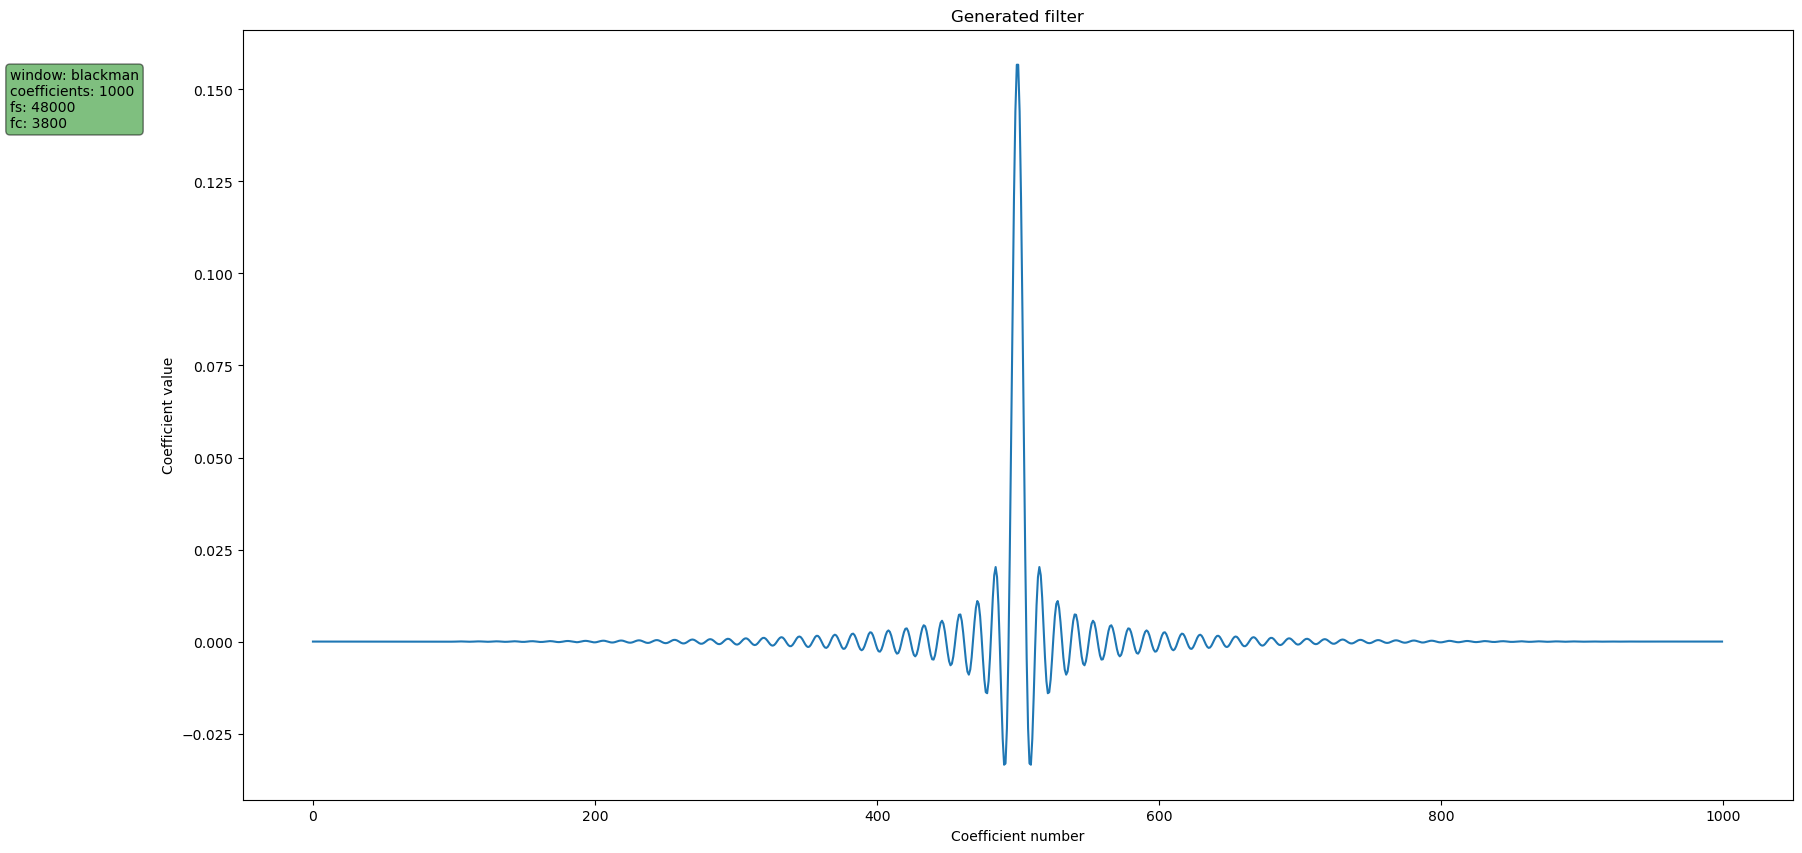

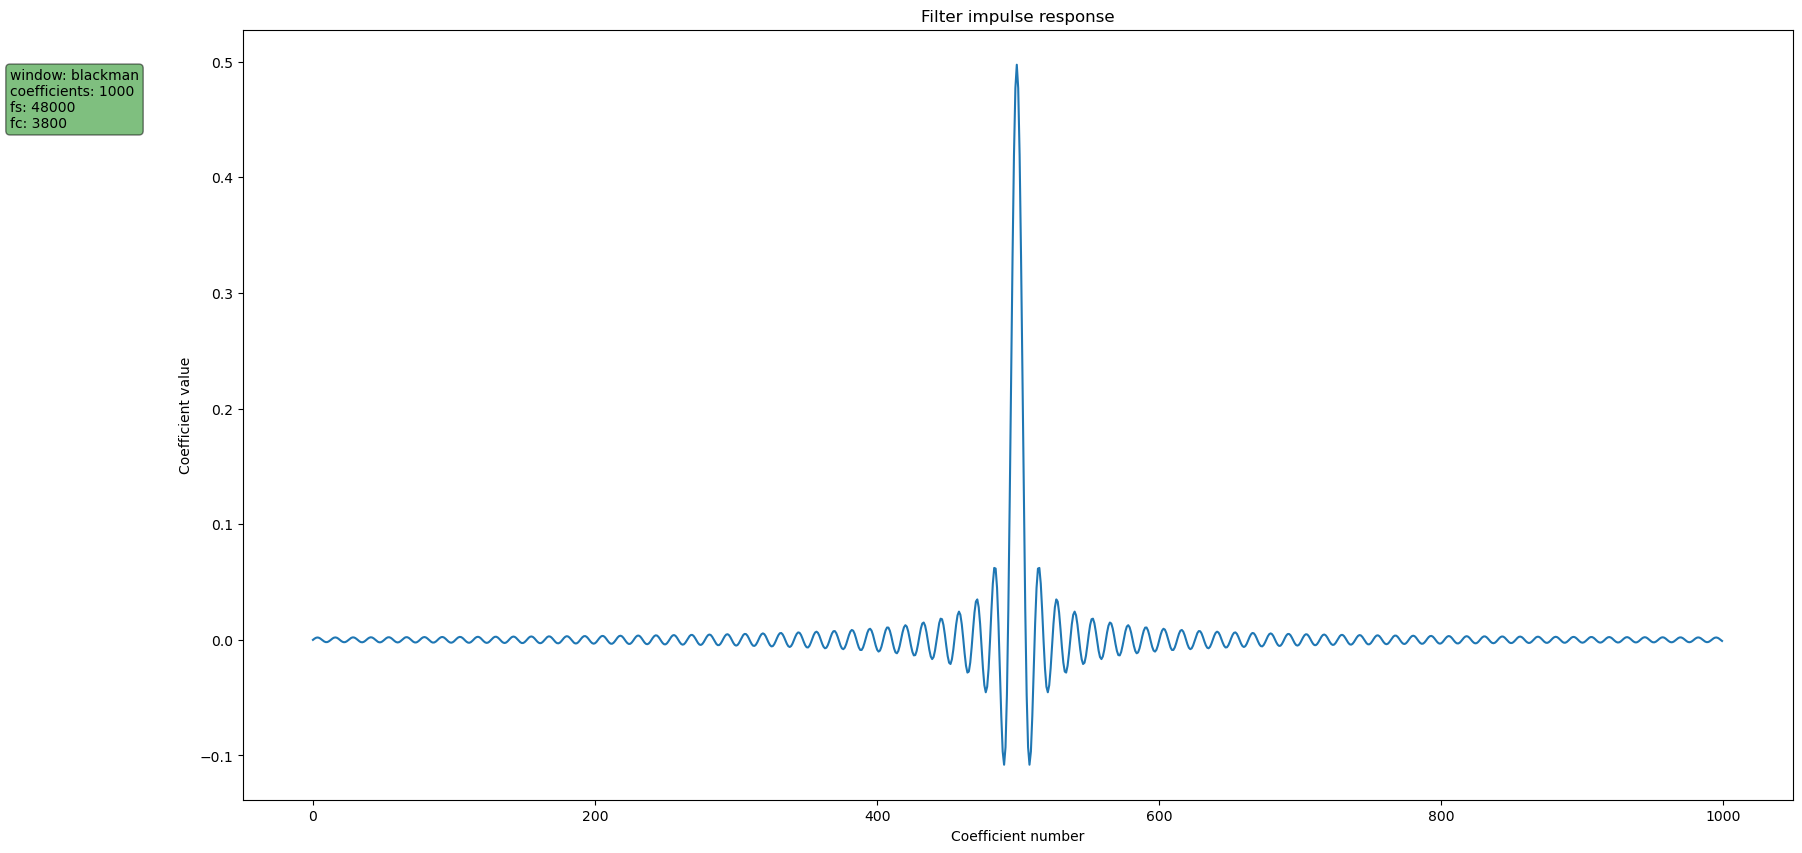

{'max_freq': 24000, 'fs': 48000, 'boundary_frequencies': array([   0, 3800]), 'bandwidth': 3800}


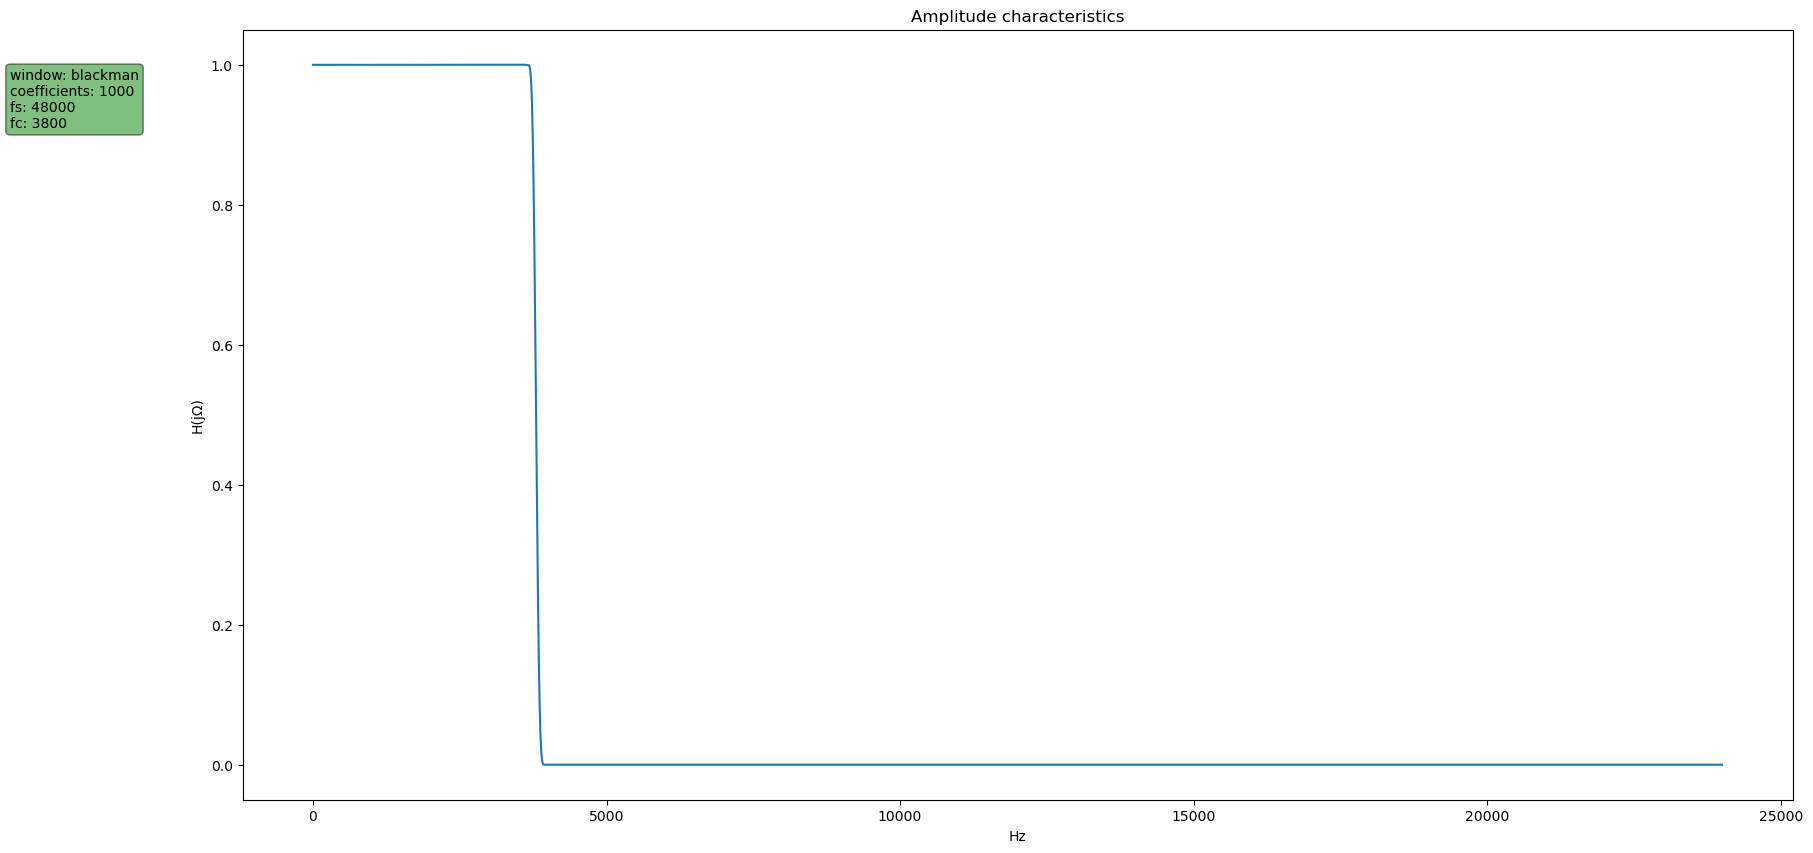

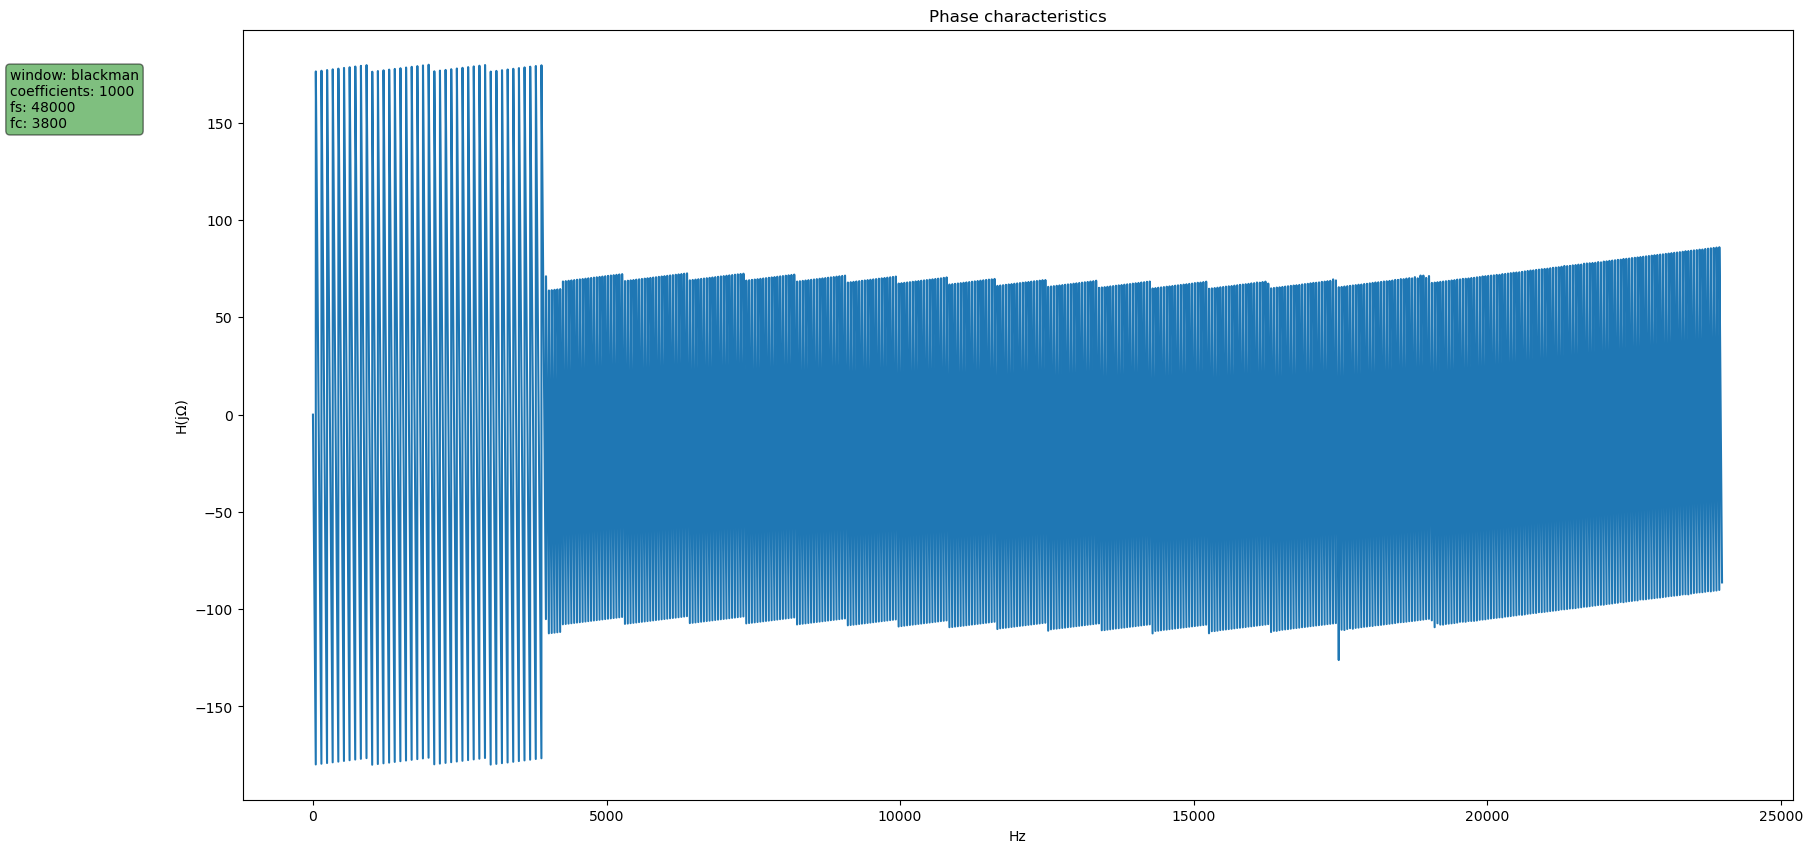

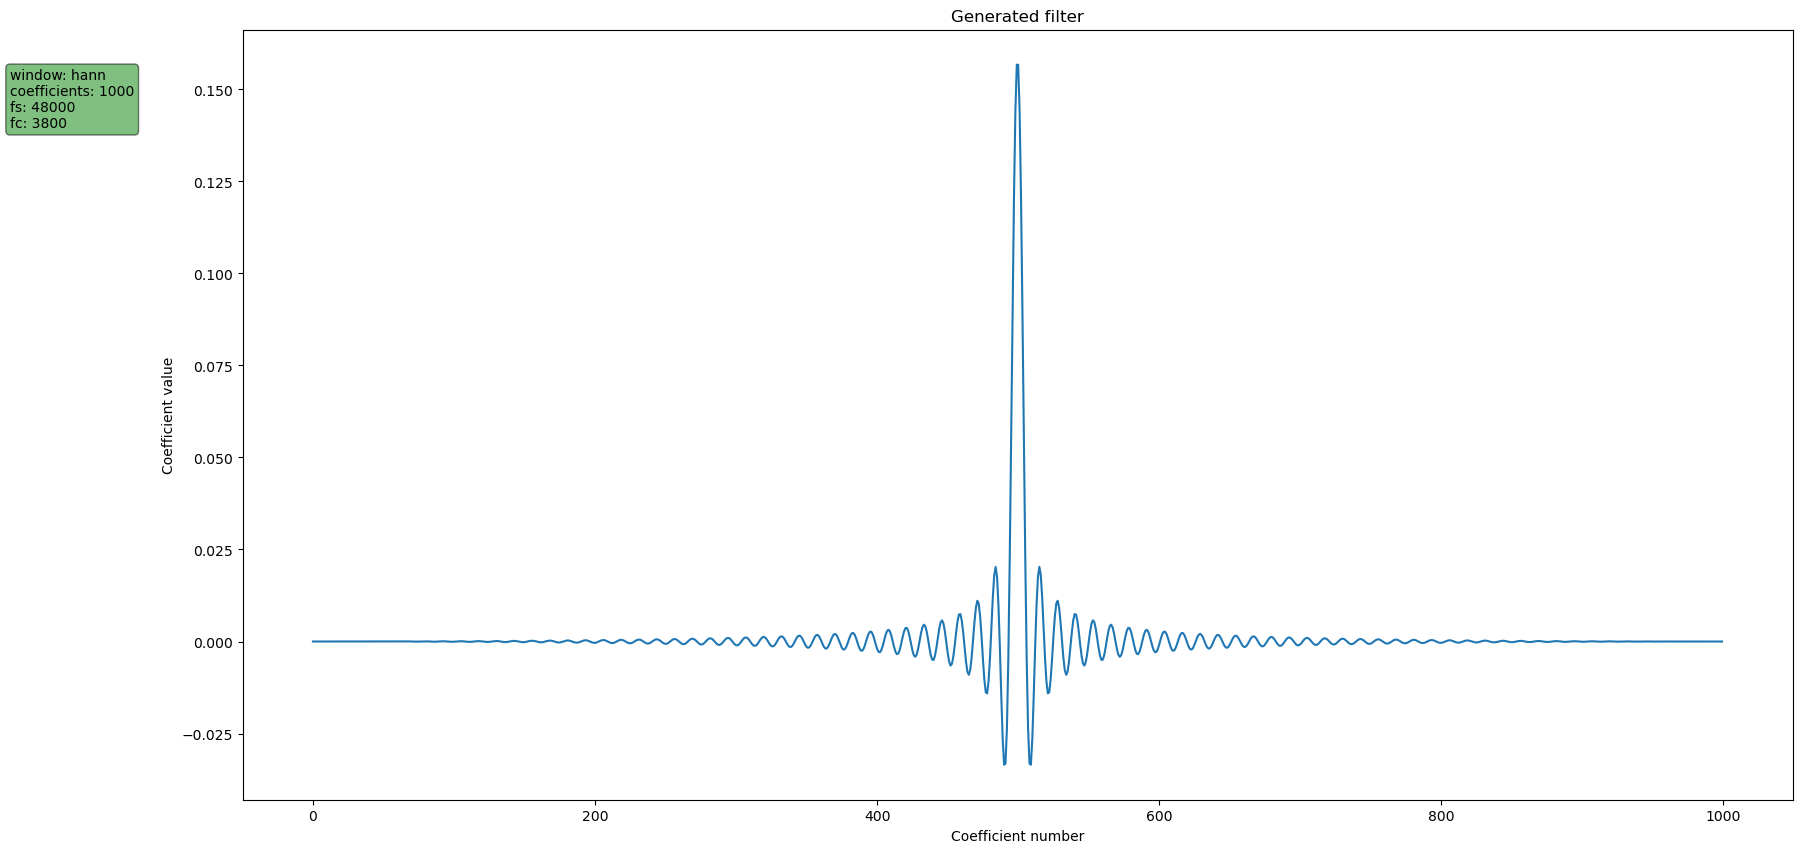

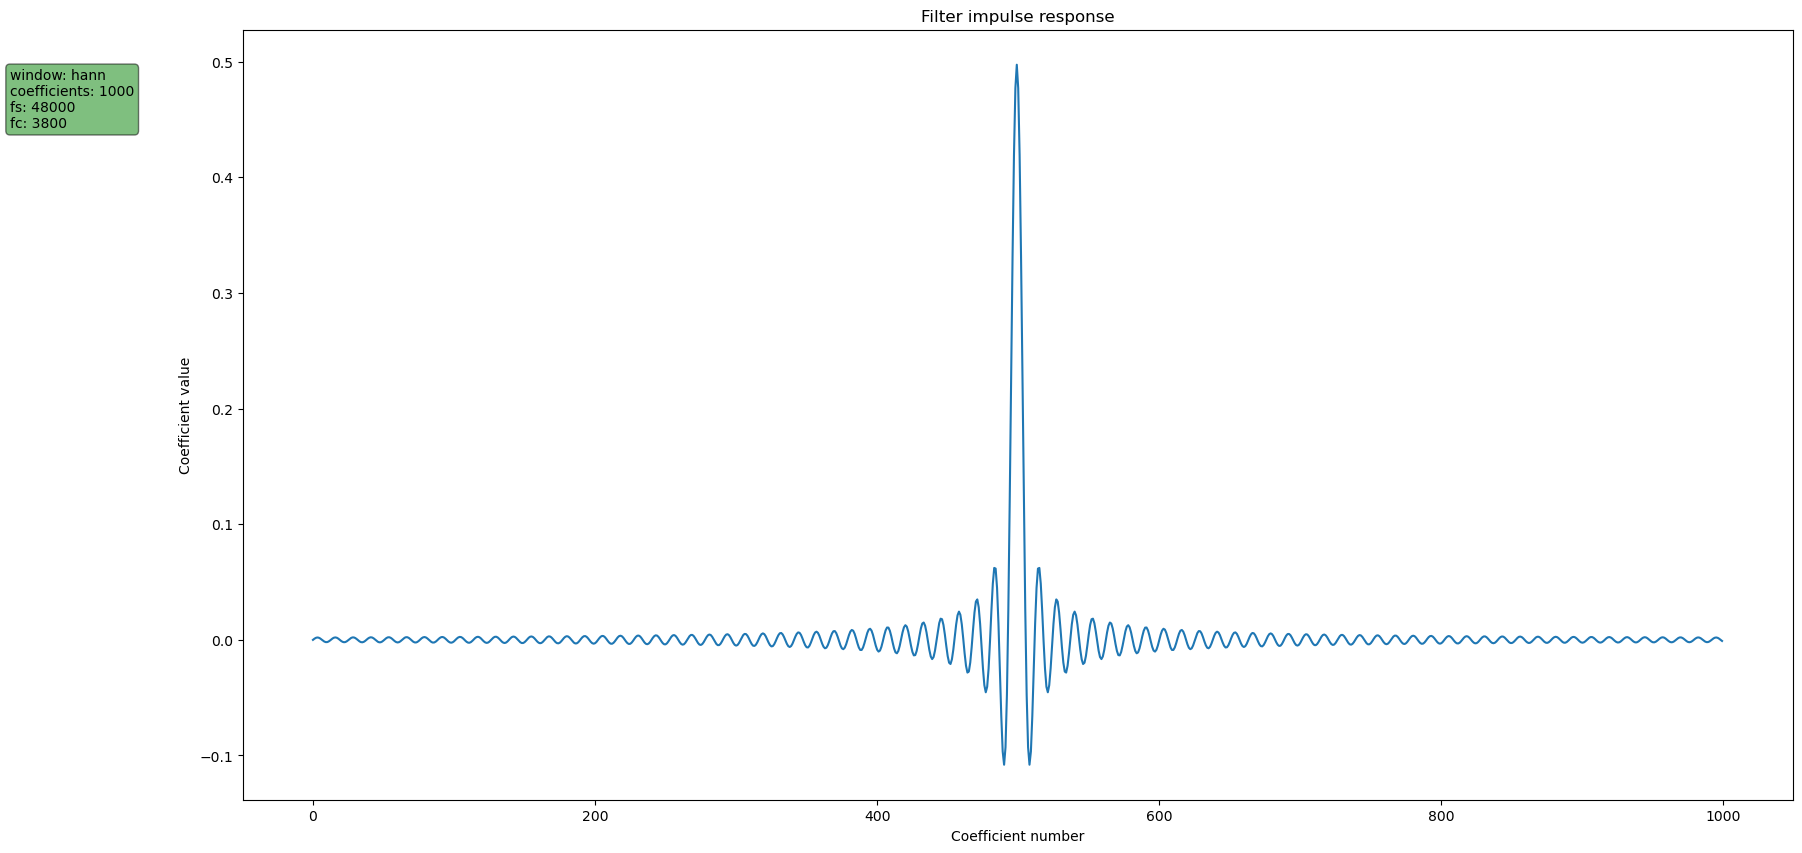

{'max_freq': 24000, 'fs': 48000, 'boundary_frequencies': array([   0, 3800]), 'bandwidth': 3800}


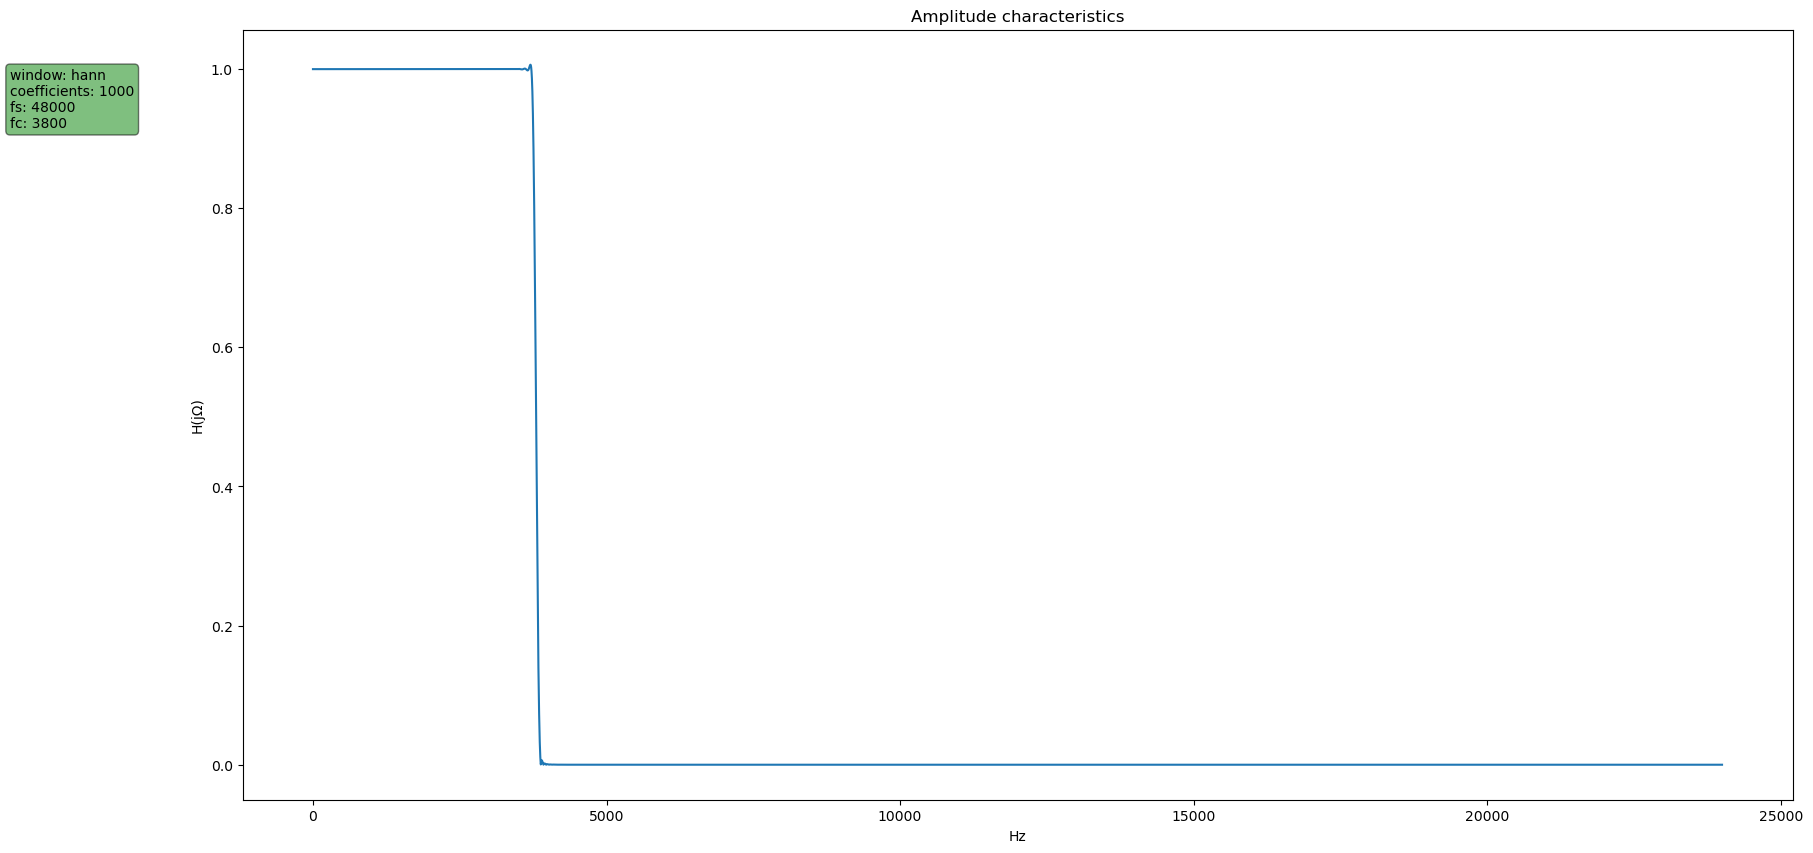

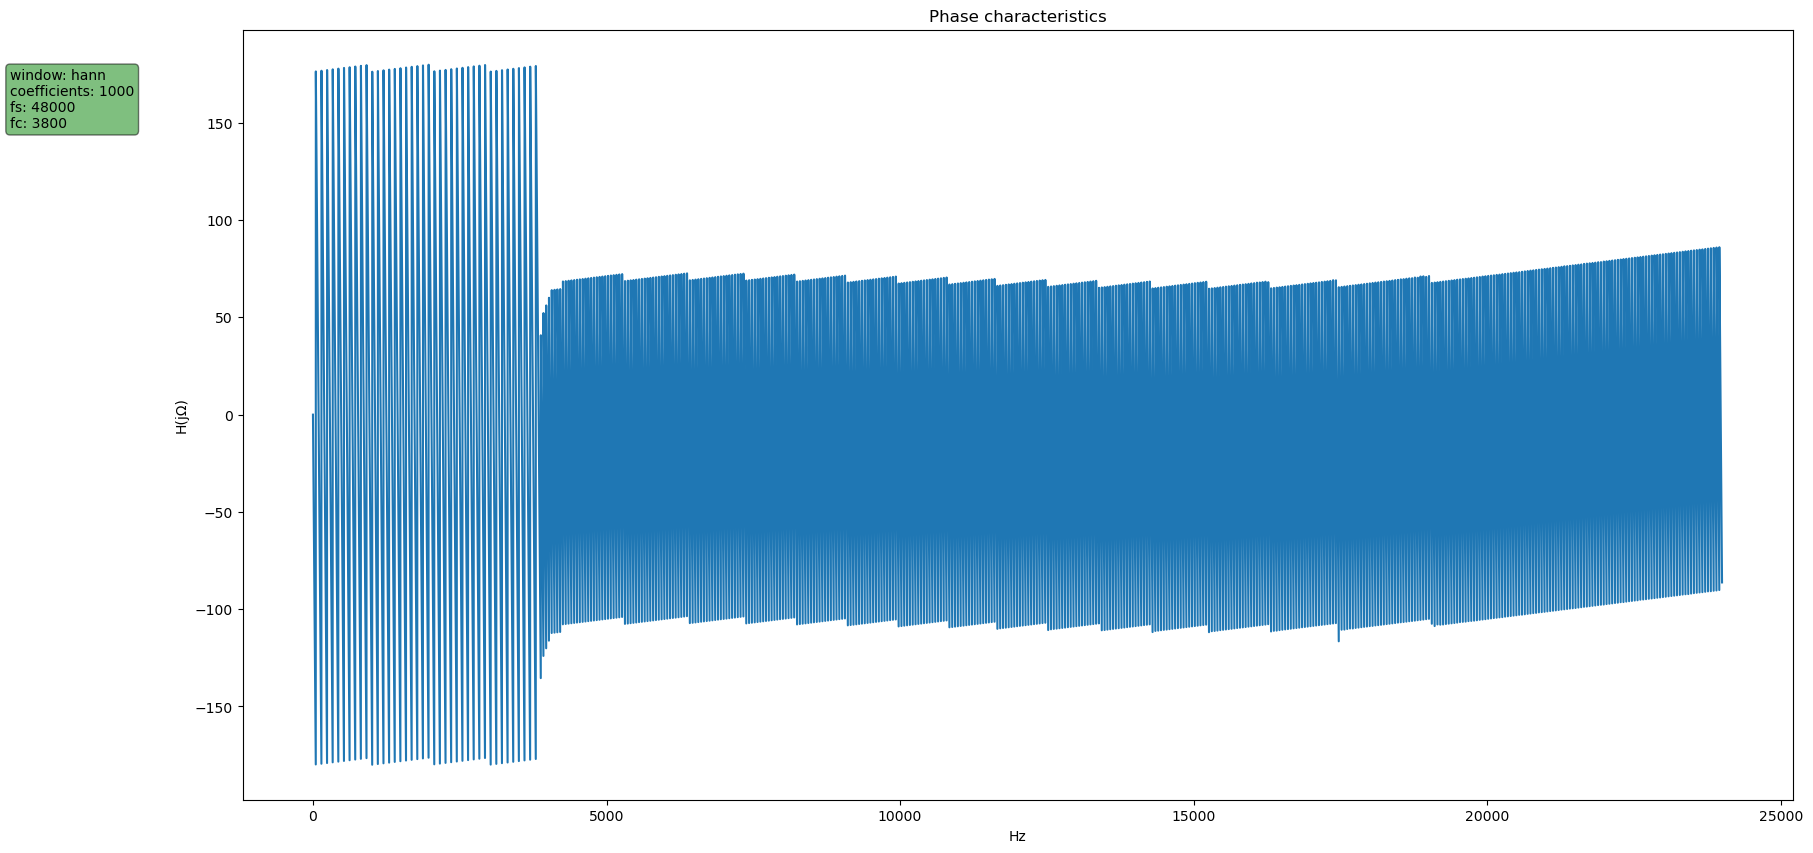

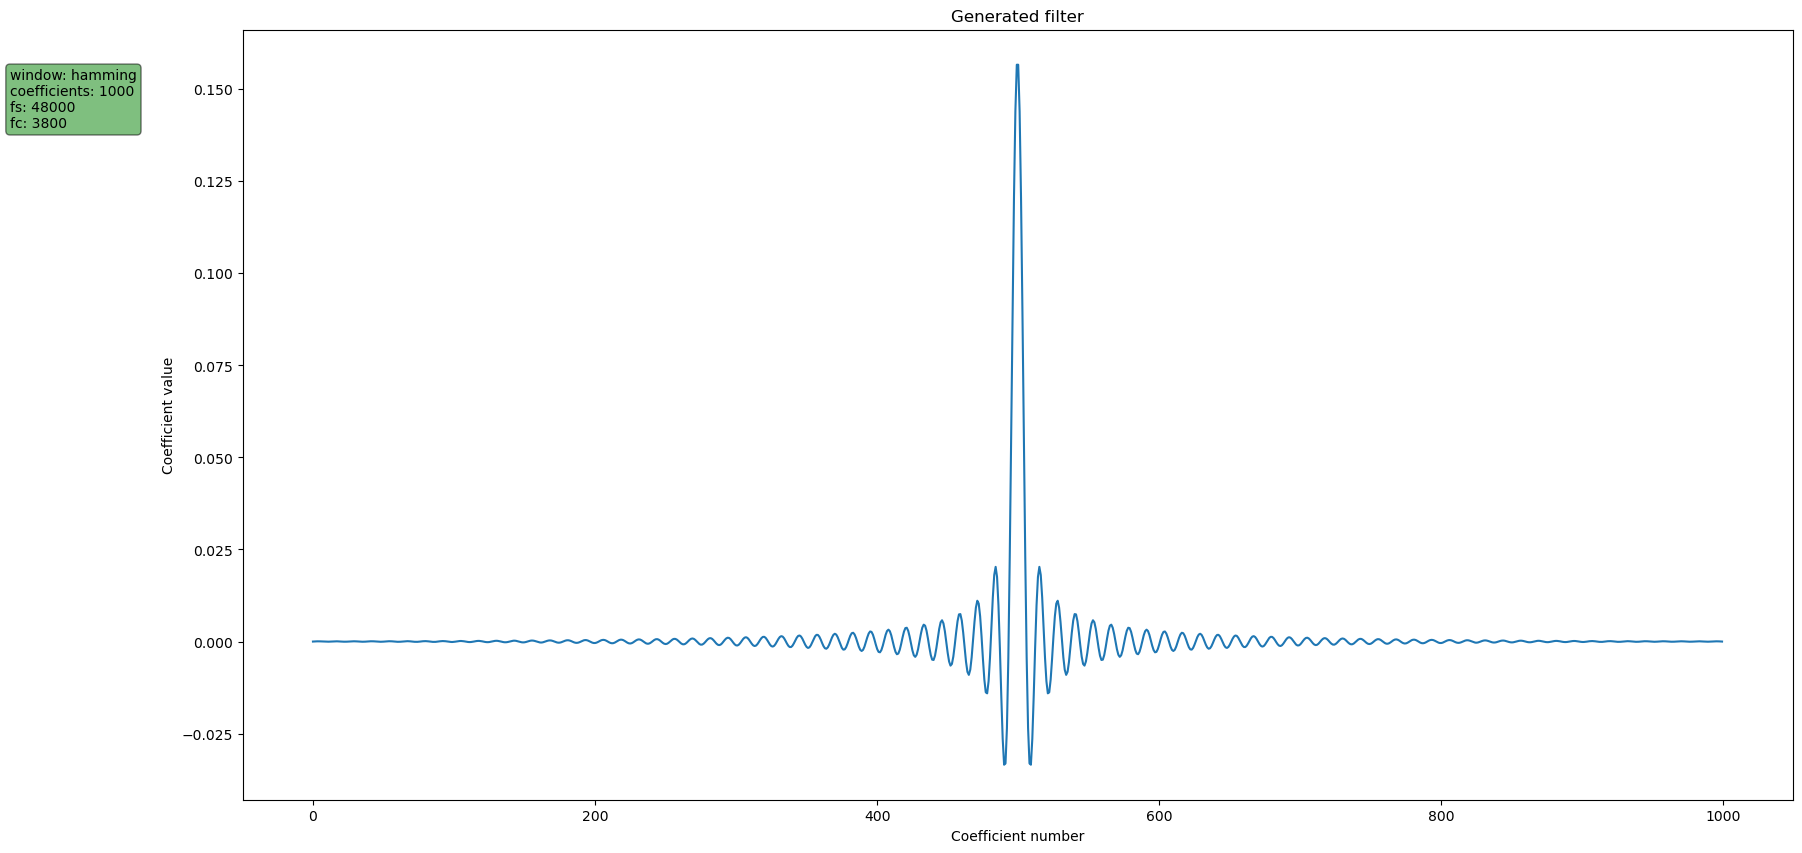

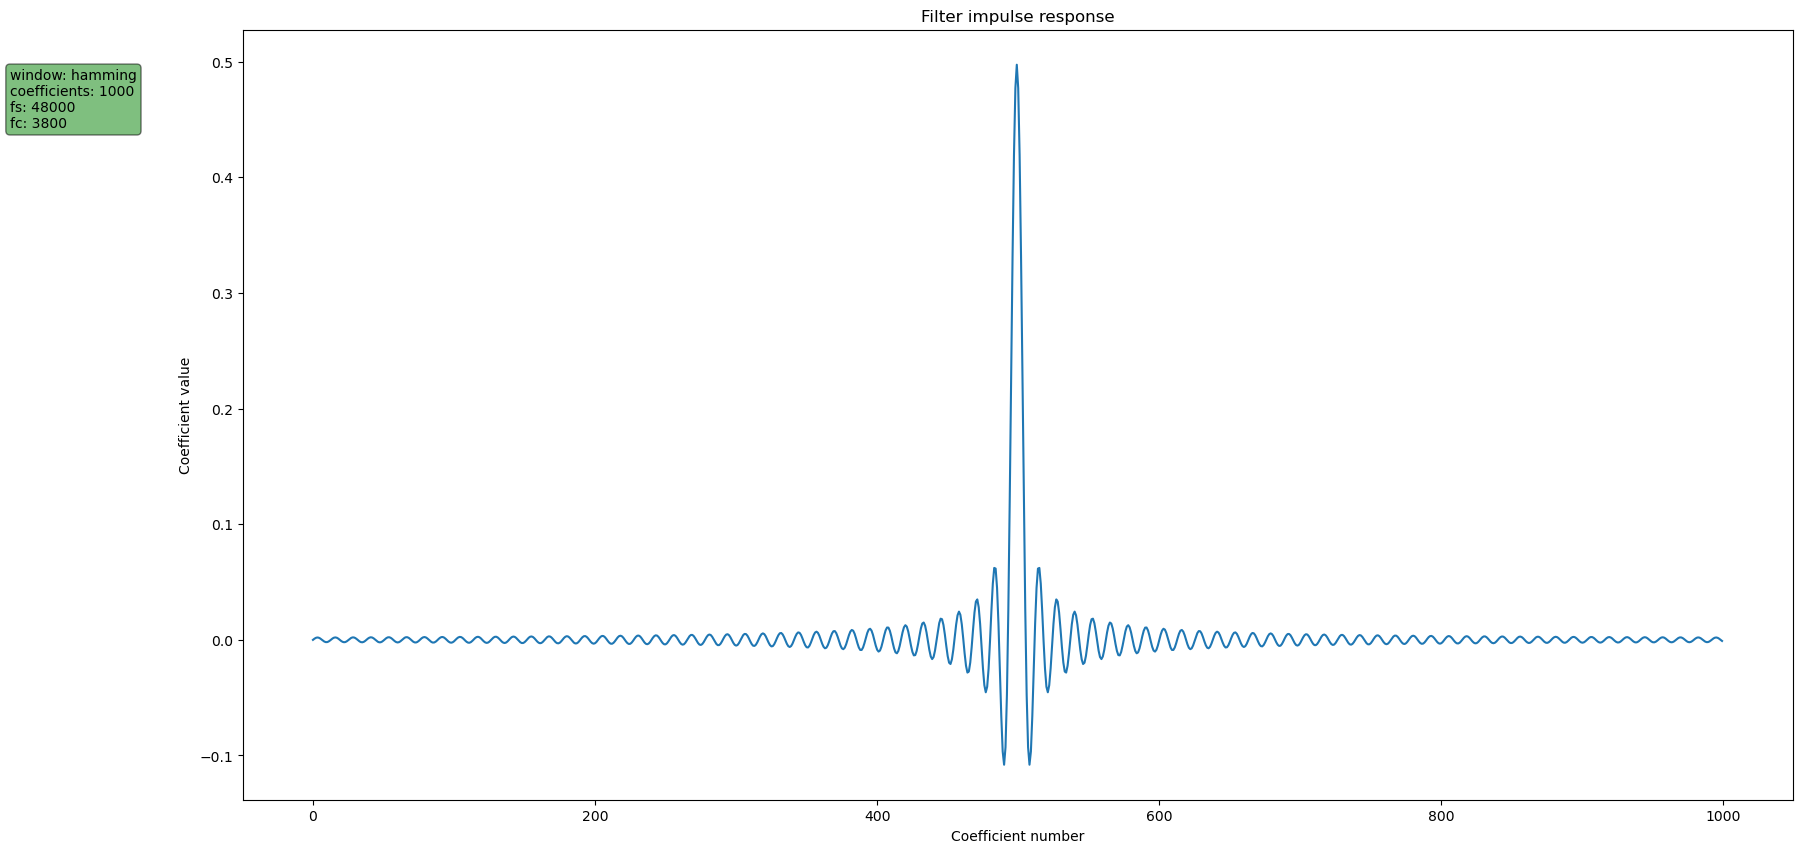

{'max_freq': 24000, 'fs': 48000, 'boundary_frequencies': array([   0, 3800]), 'bandwidth': 3800}


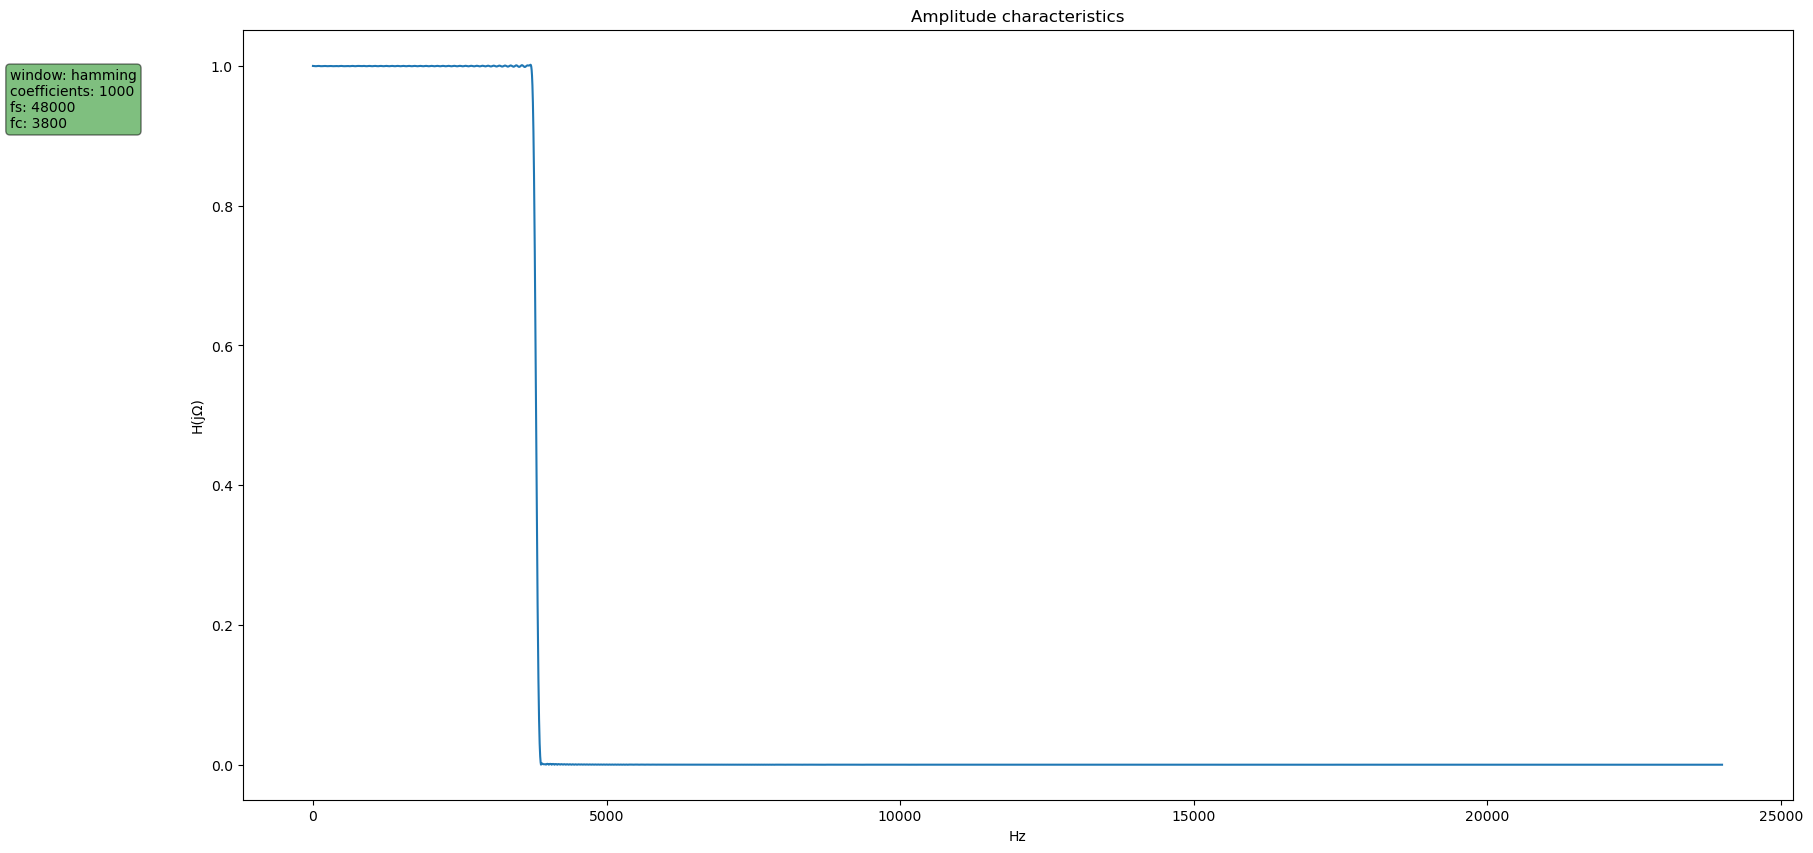

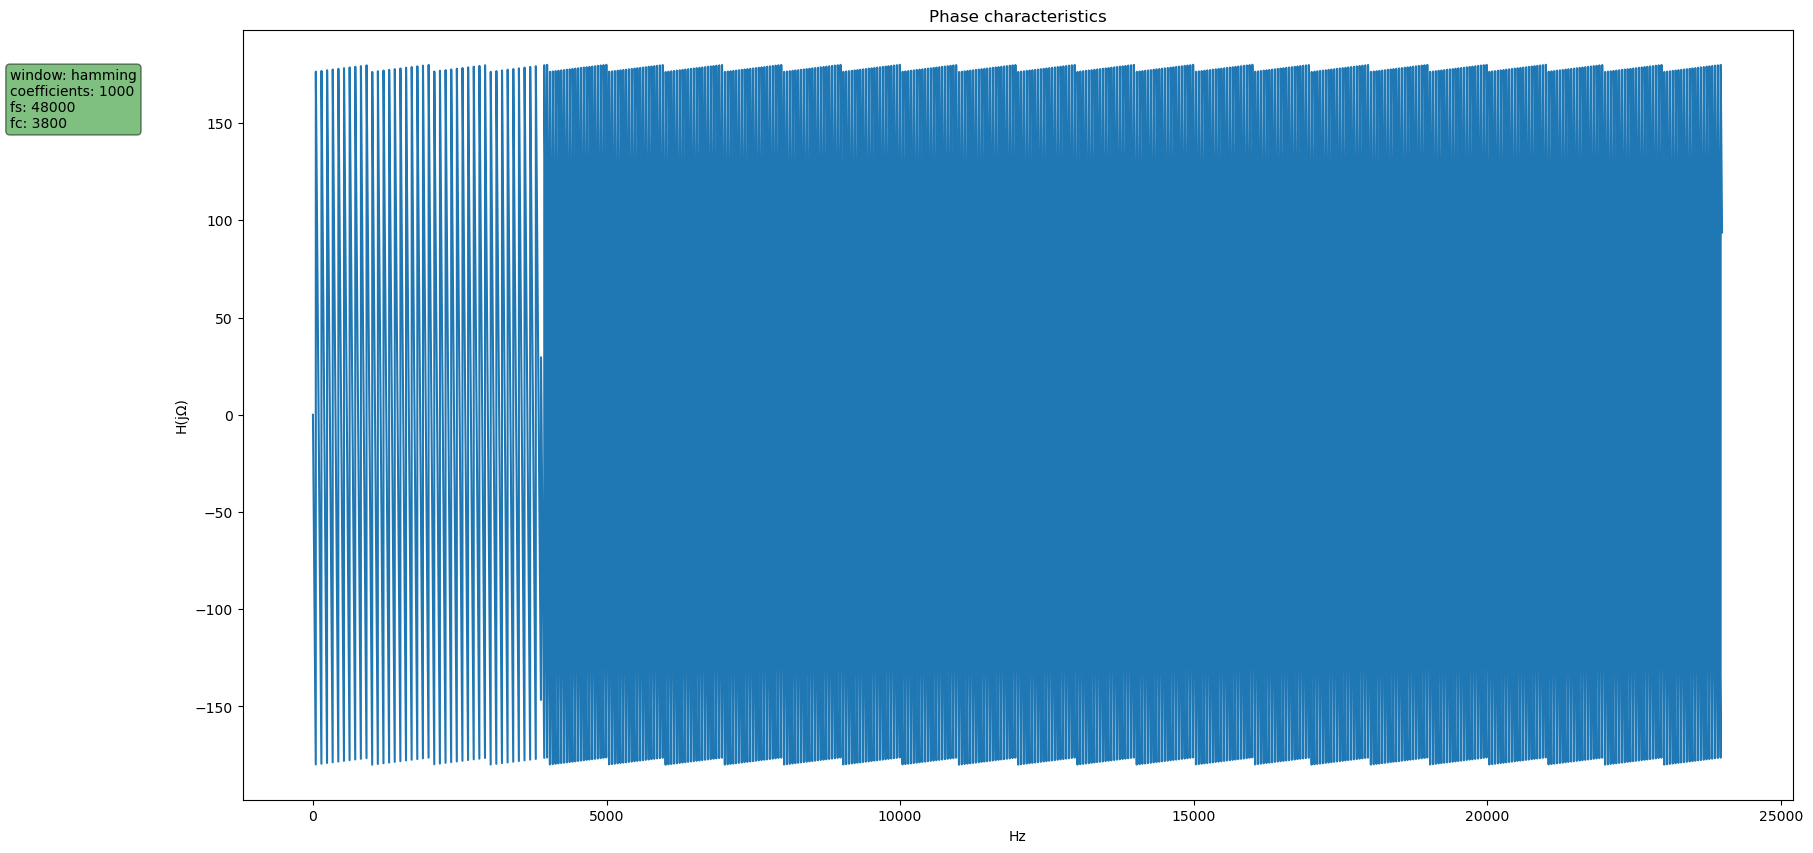

In [9]:
plots_visual_comparison()

Wnioski:
* Różnice w wizualizacjach odpowiedzi impulsowych pomiędzy poszczególnymi metodami okna są praktycznie niezauważalne. Może to wynikać z faktu, że idealna odpowiedź impulsowa jest już obliczana w momencie wyliczania współczynników filtra i ponowne jej wyliczenie nic nie zmienia. Jednak kod został napisany w celu przyswojenia zagadnienia oraz jego utrwalenia.
* Zauważalne różnice są widoczne w charakterystykach fazowych, mniej w amplitudowych. W amplitudowych charakterystykach widoczne są delikatne zmiany przy spadku wartości. W charakterystykach fazowych zmiany są widoczne gołym okiem.
* Wszystkie zmiany w charakterystykach amplitudowych i częstotliwościowych zaczynają się z momencie częstotliwości granicznej.

Wizualizacja poszczególnych charakterystyk amplitudowych i częstotliwościowych filtru z dla różnego rzędu filtru:

{'max_freq': 24000, 'fs': 48000, 'boundary_frequencies': array([   0, 3798]), 'bandwidth': 3798}


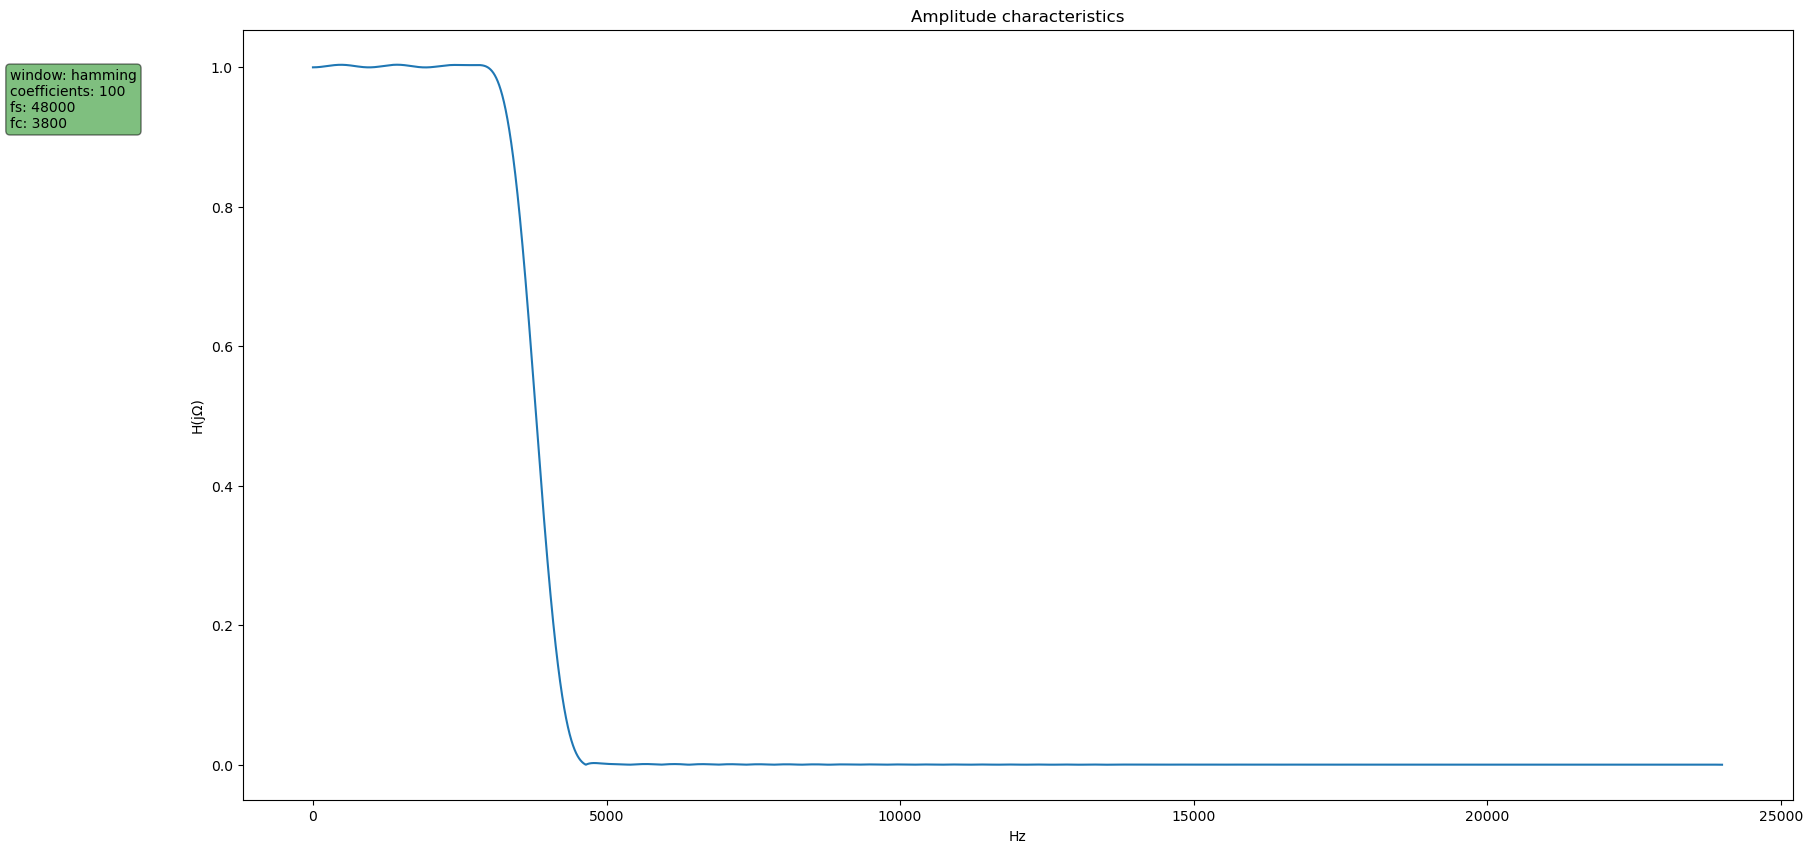

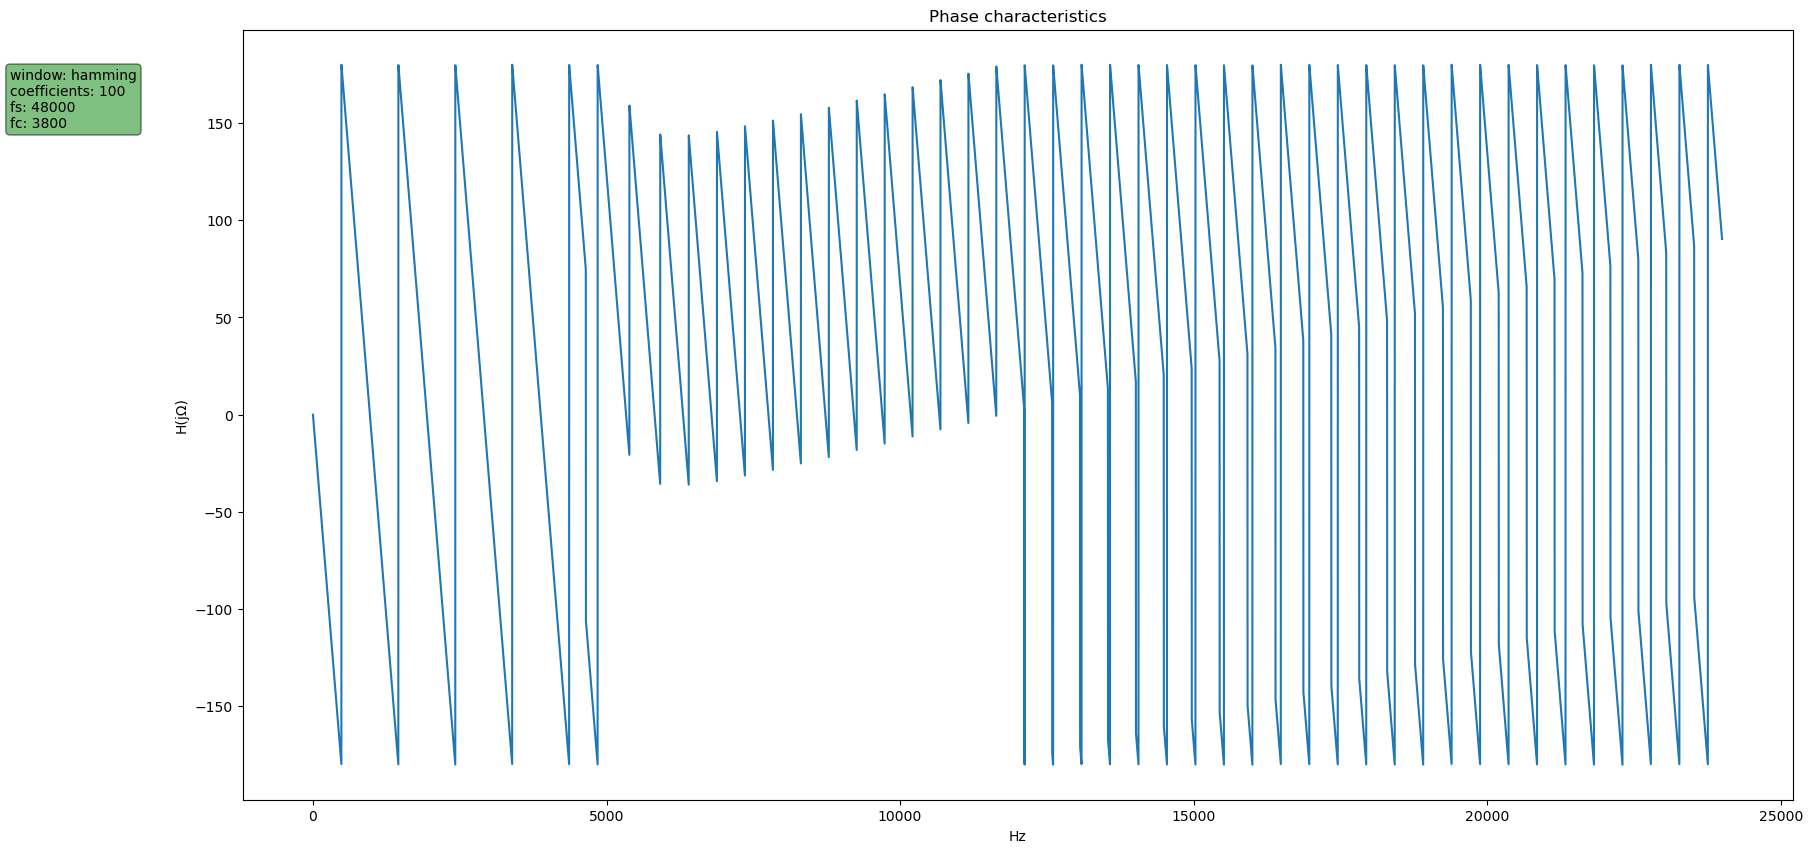

{'max_freq': 24000, 'fs': 48000, 'boundary_frequencies': array([   0, 3800]), 'bandwidth': 3800}


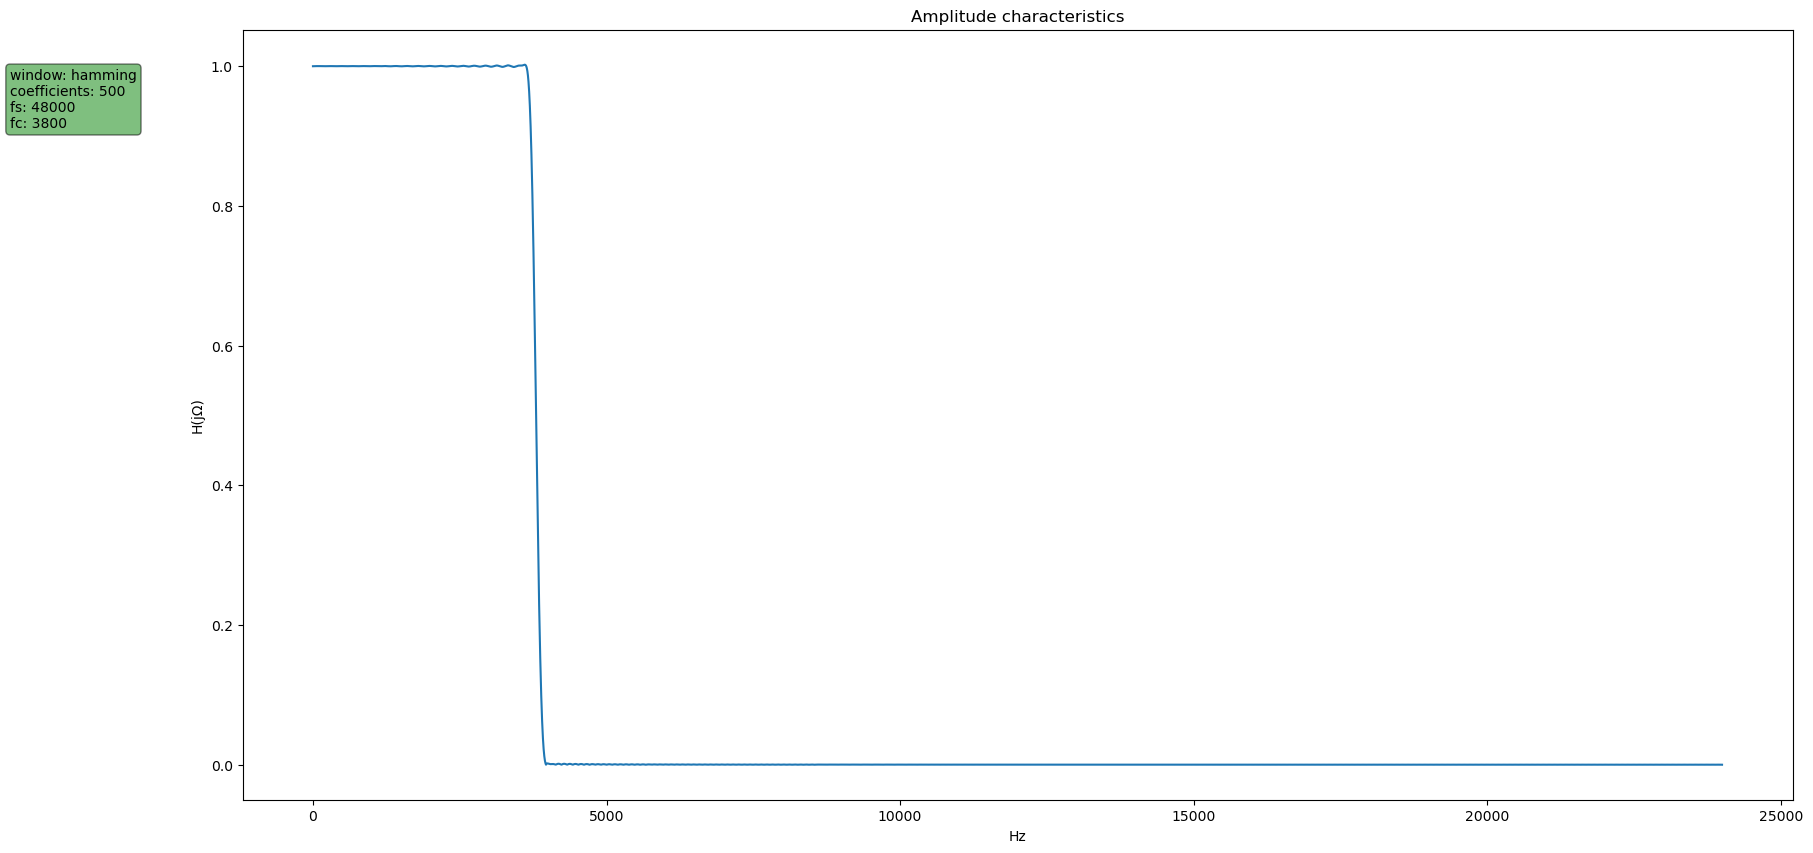

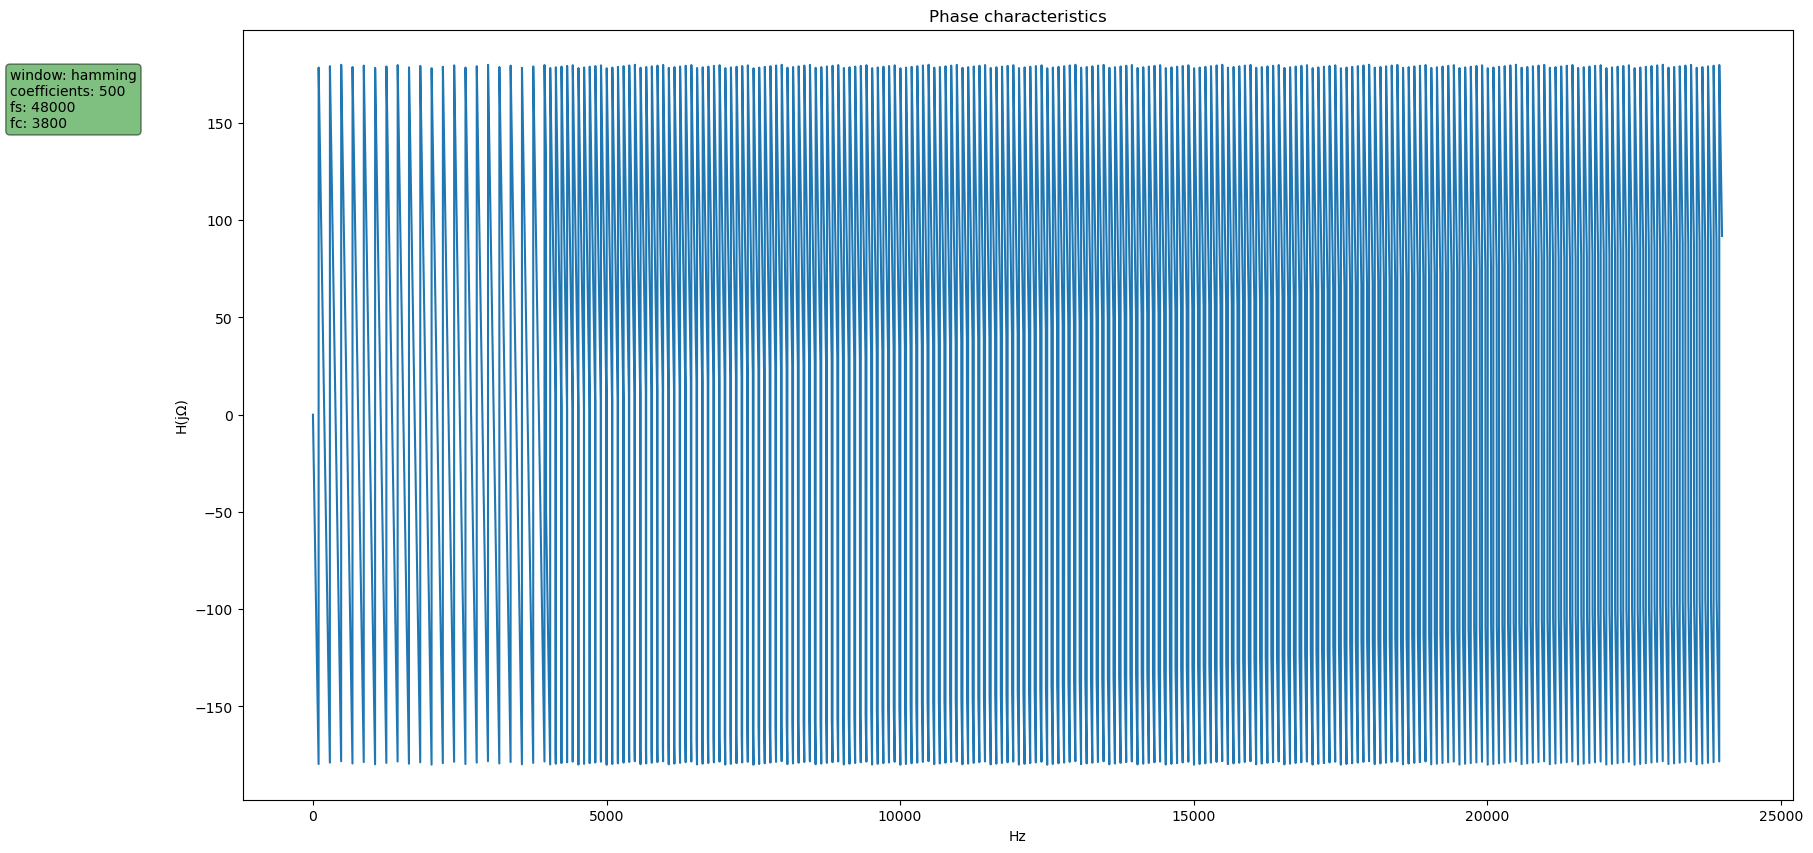

{'max_freq': 24000, 'fs': 48000, 'boundary_frequencies': array([   0, 3800]), 'bandwidth': 3800}


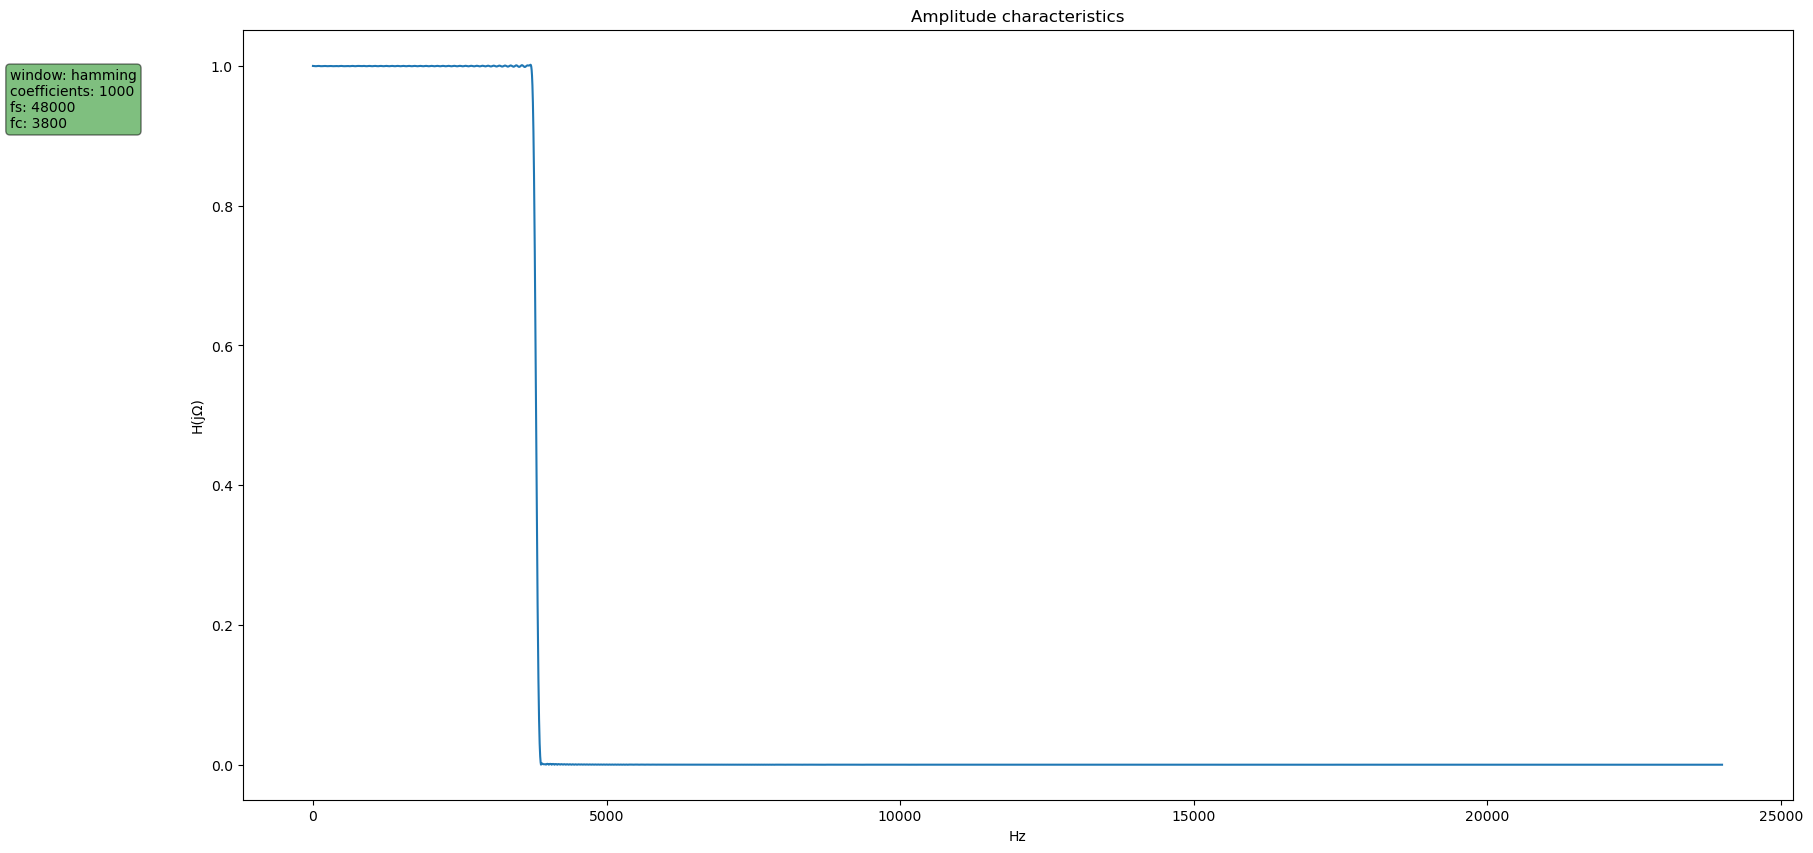

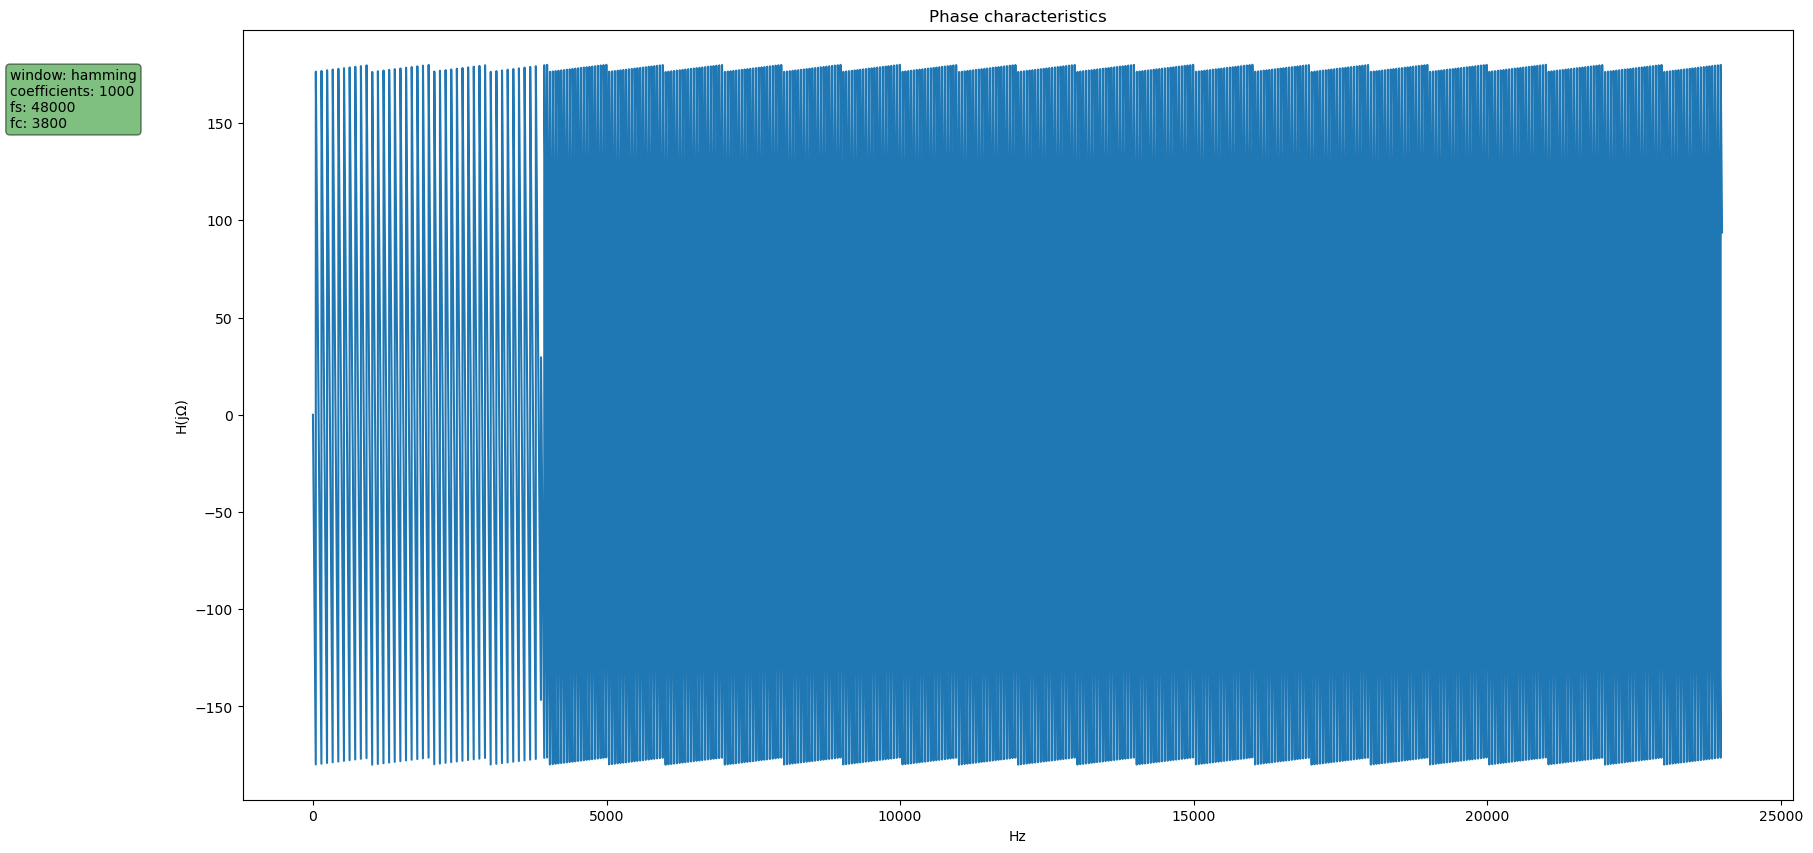

{'max_freq': 24000, 'fs': 48000, 'boundary_frequencies': array([   0, 3800]), 'bandwidth': 3800}


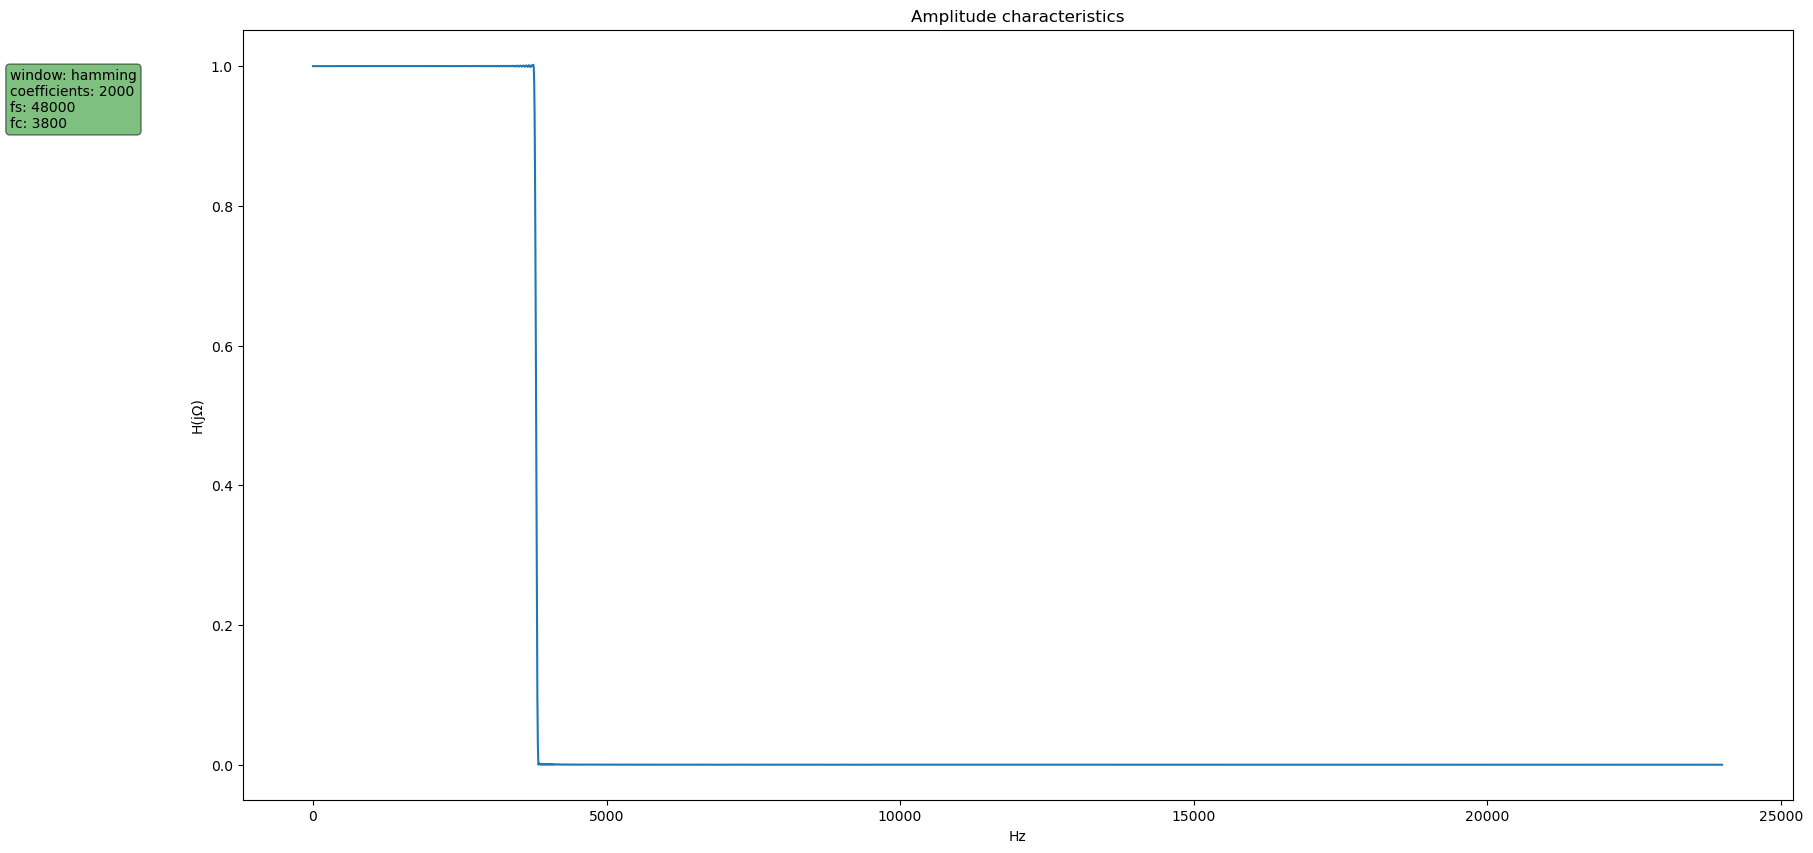

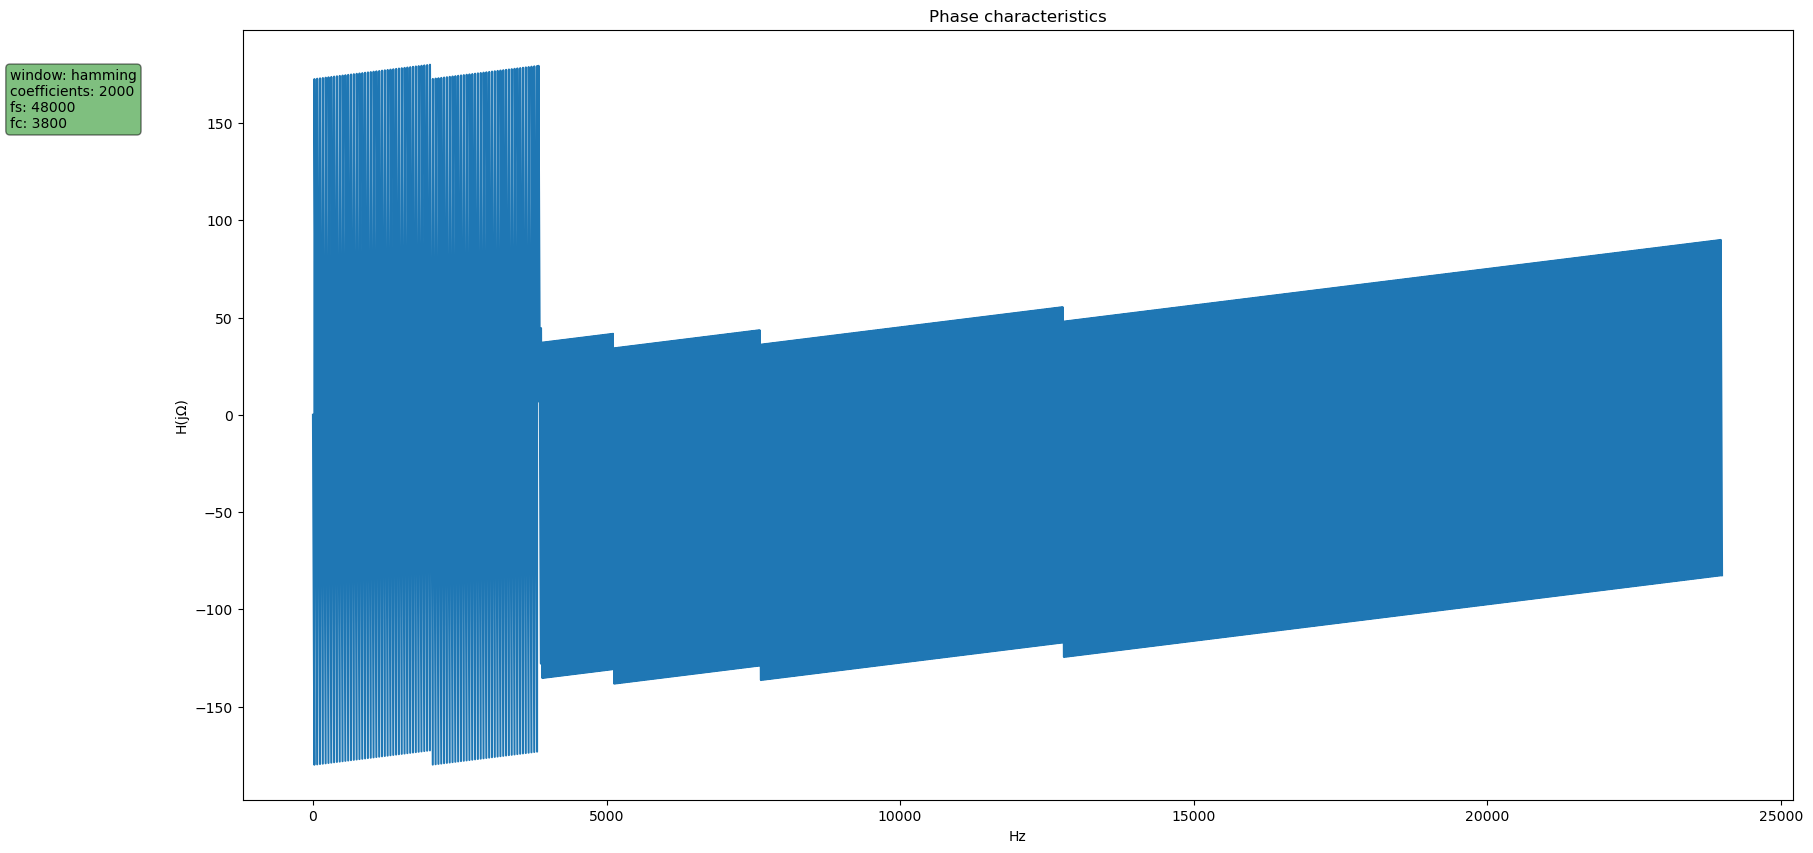

{'max_freq': 24000, 'fs': 48000, 'boundary_frequencies': array([   0, 3800]), 'bandwidth': 3800}


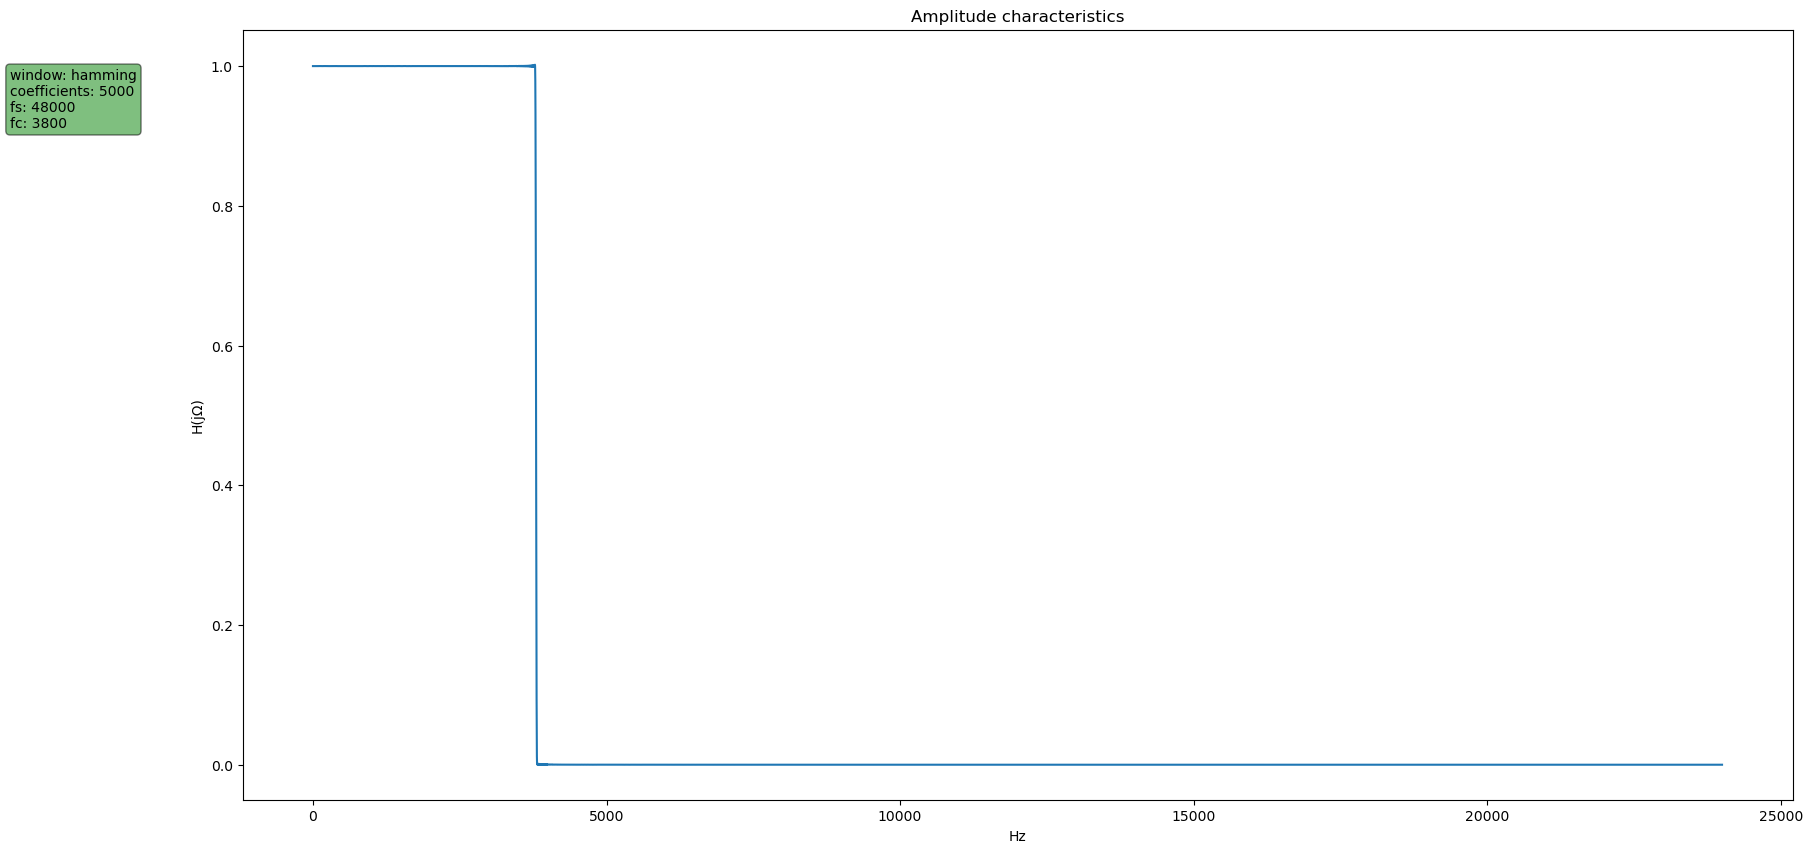

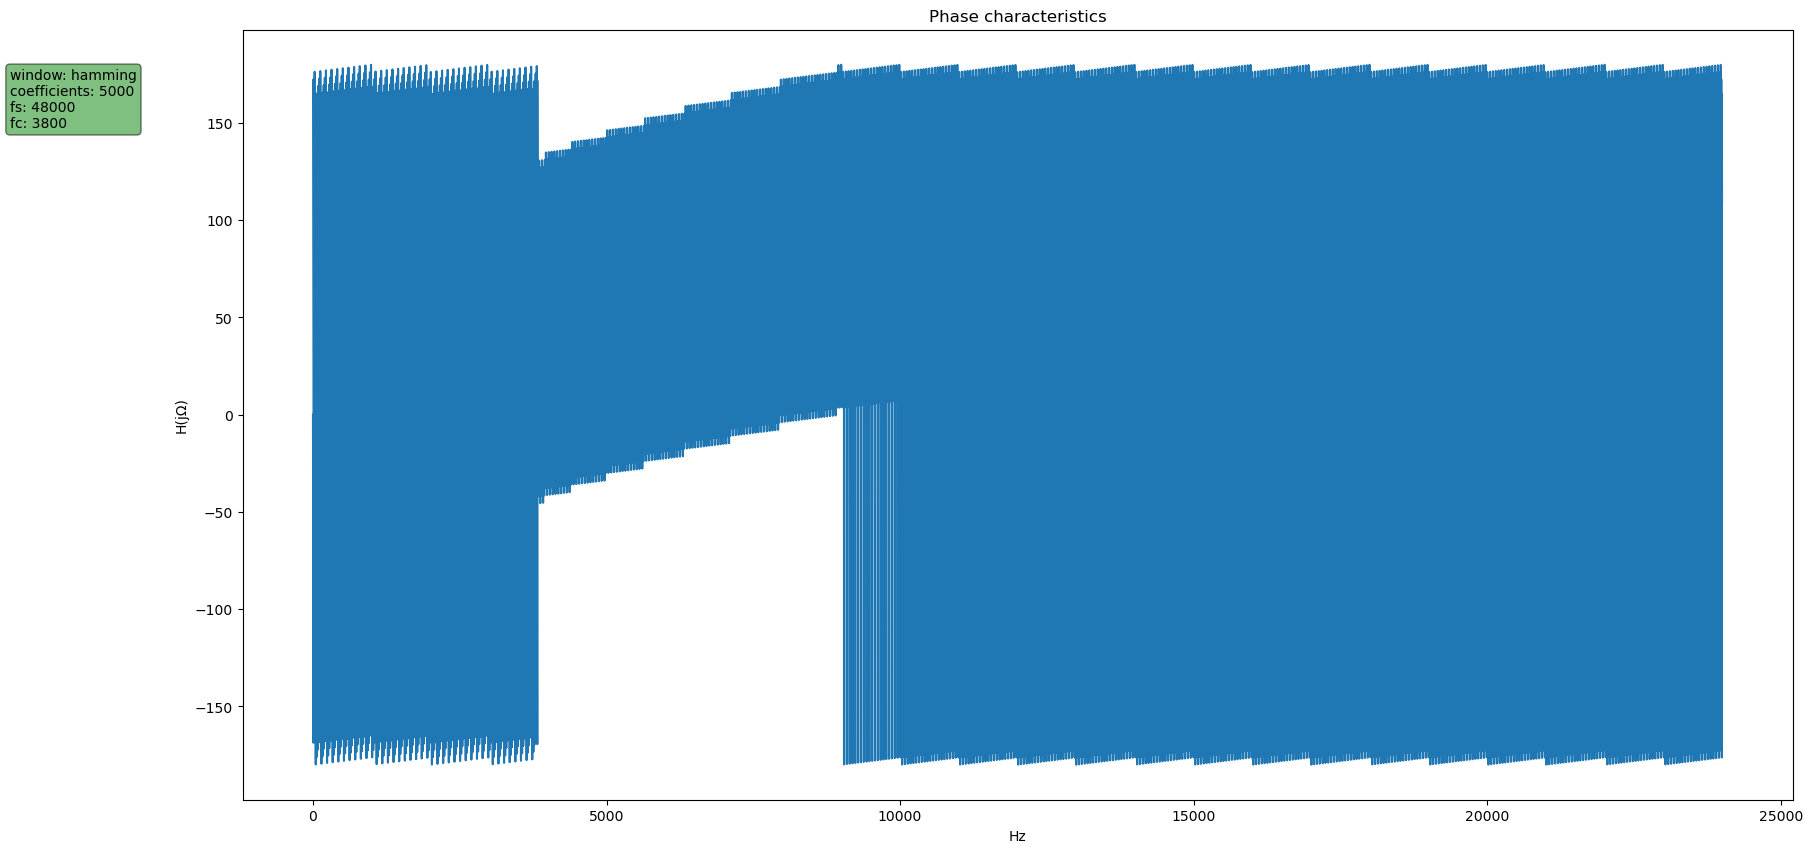

In [10]:
compare_characteristics()

Wnioski:
* Wpływ rzędu filtru wpływa na charakterystyki amplitudowe i fazowe.
* Im większy rząd filtru, tym bardziej strome jest ucięcie przepuszczanych wartości widoczne na wykresie charakterystyki amplitudowej.
* W charakterystyce fazowej jest różnie. Najpierw wraz ze wzrostem rzędu filtru wykres coraz bardziej się zagęszcza, jednak w pewnym momencie całkowicie zmienia on swoją charakterystykę.
* Tutaj również jest widoczne, że wykres zmienia się w momencie częstotliwości granicznej.